# Language Corpus Collection and Voynich Manuscript Analysis

This notebook provides tools for collecting language corpora from Wikipedia and analyzing text using Stolfi's grammar rules, specifically tailored for the Voynich Manuscript. The code has been refactored to remove duplications, improve readability, and follow professional coding standards with comprehensive comments.

## Overview
- **Corpus Collection**: Collects text data for natural and constructed languages from Wikipedia and Bible sources (where applicable).
- **Voynich Analysis**: Analyzes text using Zipf's Law, Shannon Entropy, Stolfi's grammar rules, focusing on word structure, density profiles, and compliance.

In [1]:
!pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Collecting Data

This language sample represents major language families and typological varieties essential for comparative linguistic analysis when deciphering unknown languages. The selection includes Indo-European languages (English, Spanish, German, Russian, French, Polish, Bulgarian, Greek, Albanian, Romanian, Irish, Latin, Hebrew), Uralic languages (Finnish, Hungarian), and constructed languages (Esperanto), along with a simplified English variant. 

This broad representation is crucial because unknown languages often share structural features, borrowed vocabulary, or historical connections with known language families. By comparing functional words, grammatical patterns, and phonological structures across this typologically diverse set, we can identify potential language family affiliations, detect borrowing patterns, and recognize universal linguistic tendencies. The inclusion of both ancient (Latin, Hebrew) and modern languages, along with geographically dispersed varieties, maximizes the likelihood of finding meaningful correspondences and helps eliminate false cognates, making this collection an invaluable reference framework for systematic language decipherment efforts.

In [3]:
import wikipedia
import time
from pathlib import Path

class UniversalCorpusCollector:
    def __init__(self, natural_corpus_dir="language_corpora", constructed_corpus_dir="constructed_language_corpora"):
        # Setup directories
        self.natural_corpus_dir = Path(natural_corpus_dir)
        self.constructed_corpus_dir = Path(constructed_corpus_dir)
        self.natural_corpus_dir.mkdir(exist_ok=True)
        self.constructed_corpus_dir.mkdir(exist_ok=True)
        
        # Collection target
        self.target_words = 20000
        self.min_words = 5000
        
        # Define languages
        self.languages = {
            # Natural languages
            'english': {'type': 'natural', 'iso': 'en', 'wiki': 'en', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'spanish': {'type': 'natural', 'iso': 'es', 'wiki': 'es', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'french': {'type': 'natural', 'iso': 'fr', 'wiki': 'fr', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'german': {'type': 'natural', 'iso': 'de', 'wiki': 'de', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'russian': {'type': 'natural', 'iso': 'ru', 'wiki': 'ru', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'turkish': {'type': 'natural', 'iso': 'tr', 'wiki': 'tr', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'finnish': {'type': 'natural', 'iso': 'fi', 'wiki': 'fi', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'hungarian': {'type': 'natural', 'iso': 'hu', 'wiki': 'hu', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'basque': {'type': 'natural', 'iso': 'eu', 'wiki': 'eu', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'polish': {'type': 'natural', 'iso': 'pl', 'wiki': 'pl', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'bulgarian': {'type': 'natural', 'iso': 'bg', 'wiki': 'bg', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'greek': {'type': 'natural', 'iso': 'el', 'wiki': 'el', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'albanian': {'type': 'natural', 'iso': 'sq', 'wiki': 'sq', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'romanian': {'type': 'natural', 'iso': 'ro', 'wiki': 'ro', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'irish': {'type': 'natural', 'iso': 'ga', 'wiki': 'ga', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'maltese': {'type': 'natural', 'iso': 'mt', 'wiki': 'mt', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'arabic': {'type': 'natural', 'iso': 'ar', 'wiki': 'ar', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'hebrew': {'type': 'natural', 'iso': 'he', 'wiki': 'he', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            'latin': {'type': 'natural', 'iso': 'la', 'wiki': 'la', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature']},
            # Constructed languages
            'simple_english': {'type': 'constructed', 'iso': 'en', 'wiki': 'simple', 'search_terms': ['history', 'culture', 'geography', 'science', 'literature', 'art']},
            'esperanto': {'type': 'constructed', 'iso': 'eo', 'wiki': 'eo', 'search_terms': ['historio', 'kulturo', 'geografio', 'scienco', 'literaturo', 'arto']},
            'lingua_franca_nova': {'type': 'constructed', 'iso': 'lfn', 'wiki': 'lfn', 'search_terms': ['istoria', 'cultur', 'jeografia', 'siensa', 'leteratur', 'arte']}
        }

    def get_status(self):
        """Check the status of all language corpora."""
        status = {}
        for lang, config in self.languages.items():
            dir_path = self.natural_corpus_dir if config['type'] == 'natural' else self.constructed_corpus_dir
            file_path = dir_path / f"{lang}_corpus.txt"
            if file_path.exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                word_count = len(text.split())
                status[lang] = {'exists': True, 'words': word_count, 'needs_collection': word_count < self.min_words}
            else:
                status[lang] = {'exists': False, 'words': 0, 'needs_collection': True}
        return status
    
    def collect_wikipedia_text(self, lang_name):
        """Collect Wikipedia text for a language."""
        lang_config = self.languages[lang_name]
        wikipedia.set_lang(lang_config['wiki'])
        
        collected_texts = []
        total_words = 0
        search_terms = lang_config['search_terms']
        results_limit = 2 if lang_config['type'] == 'natural' else 5
        min_content_length = 1000 if lang_config['type'] == 'natural' else 150
        
        for term in search_terms:
            if total_words >= self.target_words:
                break
            
            try:
                search_results = wikipedia.search(term, results=results_limit)
                for title in search_results:
                    if total_words >= self.target_words:
                        break
                    
                    try:
                        page = wikipedia.page(title, auto_suggest=False)
                        content = page.content
                        word_count = len(content.split())
                        
                        if word_count > min_content_length:
                            collected_texts.append(content)
                            total_words += word_count
                            print(f"    Got '{title}' ({word_count} words). Total: {total_words}")
                        
                        time.sleep(1)
                    except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError) as e:
                        print(f"    Skipping '{title}' ({type(e).__name__}).")
                    except Exception as e:
                        print(f"    Unknown error with '{title}': {e}")
            except Exception as e:
                print(f"    Error searching '{term}': {e}")
        
        return '\n\n==========\n\n'.join(collected_texts), total_words
    
    def collect_language(self, lang_name):
        """Collect corpus for one language."""
        lang_config = self.languages[lang_name]
        print(f"\n--- Collecting for {lang_name.replace('_', ' ').title()} ({lang_config['wiki']}) ---")
        
        # Collect Wikipedia text
        text, total_words = self.collect_wikipedia_text(lang_name)
        print(f"  Wikipedia: {total_words} words")
        
        # Save if enough words (same for both language types)
        dir_path = self.natural_corpus_dir if lang_config['type'] == 'natural' else self.constructed_corpus_dir
        if total_words >= self.min_words:
            file_path = dir_path / f"{lang_name}_corpus.txt"
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(text)
            print(f"Saved: {total_words} words")
            return True
        else:
            print(f"Failed: only {total_words} words")
            return False
    
    def collect_all(self):
        """Collect corpora for languages needing collection."""
        status = self.get_status()
        to_collect = [lang for lang, info in status.items() if info['needs_collection']]
        
        if not to_collect:
            print("All languages already collected!")
            return
        
        print(f"Need to collect: {len(to_collect)} languages")
        success_count = 0
        for lang in to_collect:
            if self.collect_language(lang):
                success_count += 1
        
        print(f"\nDone! Successfully collected {success_count}/{len(to_collect)} languages")
    
    def add_language(self, name, iso_code, wiki_code=None, search_terms=None, is_constructed=False):
        if wiki_code is None:
            wiki_code = iso_code
        lang_type = 'constructed' if is_constructed else 'natural'
        search_terms = search_terms or ['history', 'culture', 'geography', 'science', 'literature']
        self.languages[name] = {'type': lang_type, 'iso': iso_code, 'wiki': wiki_code, 'search_terms': search_terms}
        print(f"Added {name} ({iso_code}, {lang_type})")


if __name__ == "__main__":
    collector = UniversalCorpusCollector()
    print("Current status:")
    for lang, info in collector.get_status().items():
        status_text = f"{info['words']} words" if info['exists'] else "missing"
        print(f"  {lang}: {status_text}")
    collector.collect_all()

Current status:
  english: 78101 words
  spanish: 39864 words
  french: 81741 words
  german: 40040 words
  russian: 47249 words
  turkish: 9031 words
  finnish: 30922 words
  hungarian: 16568 words
  basque: 13262 words
  polish: 42694 words
  bulgarian: 6842 words
  greek: 42508 words
  albanian: 17461 words
  romanian: 40155 words
  irish: 7170 words
  maltese: 11912 words
  arabic: 57965 words
  hebrew: 10364 words
  latin: 6200 words
  simple_english: 32277 words
  esperanto: 22669 words
  lingua_franca_nova: 10766 words
All languages already collected!


### Data Exploration

#### Zipf's Law

Zipf's Law states that in any natural language corpus, the frequency of a word is inversely proportional to its rank—meaning the most frequent word appears twice as often as the second most frequent, three times as often as the third, and so forth. This mathematical principle is consistent across languages and provides a powerful tool for language decipherment because it allows researchers to identify the most common functional words even without understanding their meaning.

In [4]:
# Import libs
import re         
import numpy as np        
import pandas as pd     
import matplotlib.pyplot as plt  
from collections import Counter  
from scipy import stats     
from scipy.optimize import curve_fit

In [5]:
class CoreZipfAnalyzer:
    # Initialize the analyzer with empty attributes
    def __init__(self):
        self.tokens = []
        self.frequency_data = None
        self.zipf_results = {}
    
    # Define the Zipf's law function: f(r) = C / r^alpha
    def zipf_function(self, rank, C, alpha):
        # rank: word rank (1 = most frequent, 2 = second, etc.)
        # C: scaling constant
        # alpha: exponent (typically ~1 for natural languages)
        return C / (rank ** alpha)
    
    # Clean text by removing numbers, punctuation, and normalizing whitespace
    def clean_generic_text(self, text):
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text.lower()
    
    # Tokenize text into words, filtering out short tokens
    def tokenize_generic_text(self, text):
        text = self.clean_generic_text(text)
        tokens = text.split() 
        tokens = [token for token in tokens if len(token) >= 2]
        return tokens
    
    # Calculate word frequencies and ranks
    def calculate_frequencies(self, tokens):
        self.tokens = tokens
        freq_counter = Counter(tokens)
        
        freq_data = pd.DataFrame([
            {'token': token, 'frequency': freq}
            for token, freq in freq_counter.items()
        ])
        
        # Sort by frequency (descending), add rank, and compute metrics
        freq_data = freq_data.sort_values('frequency', ascending=False).reset_index(drop=True)
        freq_data['rank'] = range(1, len(freq_data) + 1)  # 1-based rank
        freq_data['relative_frequency'] = freq_data['frequency'] / len(tokens)
        freq_data['freq_rank_product'] = freq_data['frequency'] * freq_data['rank']  # Zipf product
        
        self.frequency_data = freq_data
        return freq_data
    
    # Fit Zipf's law to frequency data
    def fit_zipf_law(self):
        if self.frequency_data is None:
            return None
        
        ranks = self.frequency_data['rank'].values
        frequencies = self.frequency_data['frequency'].values
        
        try:
            # Initial guesses for curve fitting
            C_guess = frequencies[0]  # Top word's frequency
            alpha_guess = 1.0  # Zipf exponent
            
            # Fit Zipf function to data
            popt, pcov = curve_fit(self.zipf_function, ranks, frequencies, 
                                 p0=[C_guess, alpha_guess], maxfev=5000)
            
            C_fitted, alpha_fitted = popt
            predicted_freq = self.zipf_function(ranks, C_fitted, alpha_fitted)
            
            # Calculate goodness of fit
            r_squared = stats.pearsonr(frequencies, predicted_freq)[0] ** 2  # R²
            rmse = np.sqrt(np.mean((frequencies - predicted_freq) ** 2))  # Root Mean Squared Error
            
            # Log-log linear regression for validation
            log_ranks = np.log(ranks)
            log_frequencies = np.log(frequencies)
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_frequencies)
            
            # Store results
            self.zipf_results = {
                'C': C_fitted,
                'alpha': alpha_fitted,
                'r_squared': r_squared,
                'rmse': rmse,
                'log_slope': slope,
                'log_intercept': intercept,
                'log_r_squared': r_value ** 2,
                'predicted_frequencies': predicted_freq
            }
            
            return self.zipf_results
            
        except Exception as e:
            return None
    
    # Calculate basic linguistic metrics
    def calculate_language_metrics(self):
        if self.frequency_data is None:
            return None
        
        total_tokens = len(self.tokens) 
        unique_tokens = len(self.frequency_data) 
        type_token_ratio = unique_tokens / total_tokens  # Lexical diversity
        frequencies = self.frequency_data['frequency'].values
        hapax_count = sum(1 for freq in frequencies if freq == 1)  # Words appearing once
        hapax_ratio = hapax_count / unique_tokens  # Proportion of hapax legomena
        
        return {
            'total_tokens': total_tokens,
            'unique_tokens': unique_tokens,
            'type_token_ratio': type_token_ratio,
            'hapax_ratio': hapax_ratio
        }
    
    # Perform full Zipf analysis on input text
    def analyze_text(self, text, text_name="Text"):
        tokens = self.tokenize_generic_text(text)
        if len(tokens) < 100: 
            return None
        
        freq_data = self.calculate_frequencies(tokens)
        zipf_results = self.fit_zipf_law()
        if not zipf_results:
            return None
        
        metrics = self.calculate_language_metrics()
        
        # Compile all results
        complete_results = {
            'text_name': text_name,
            'tokens': tokens,
            'frequency_data': freq_data,
            'zipf_results': zipf_results,
            'metrics': metrics,
            'top_10_words': freq_data.head(10)['token'].tolist()
        }
        
        return complete_results

Voynich Zipf-Mandelbrot Analysis Results:
C (constant): 8617.87
α (exponent): 1.07
β (offset): 10.19
R²: 0.9905
RMSE: 2.1985


,Language,Type,Total_Tokens,Unique_Tokens,Type_Token_Ratio,Hapax_Ratio,Zipf_C,Zipf_Alpha,Zipf_Beta,R_Squared,RMSE,Log_Slope,Log_R_Squared
0,Voynich Manuscript,Unknown,38002,8442,0.222146,0.710495,8617.8674,1.067241,10.190708,0.990546,2.198545,-0.881681,0.902885


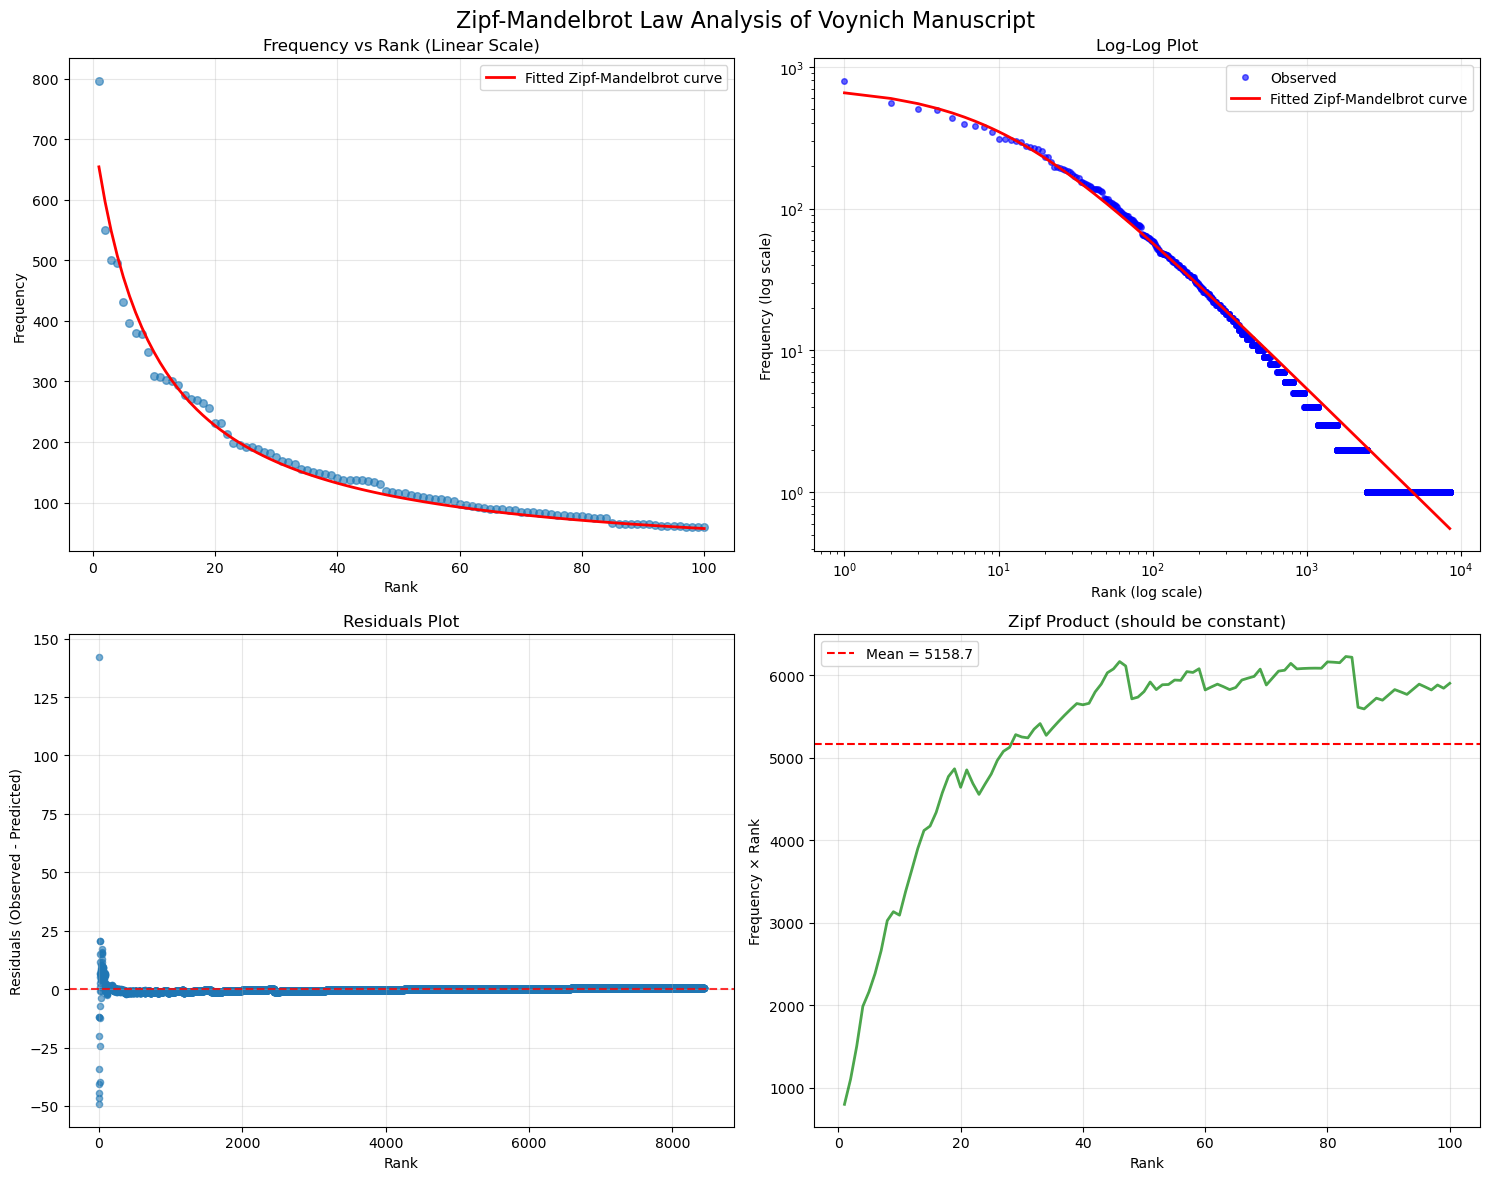

In [6]:
# Specialized class for analyzing the Voynich Manuscript with Zipf-Mandelbrot law
class VoynichZipfAnalyzer:
    def __init__(self, treat_commas_as_spaces=True):
        # Initialize with core analyzer and Voynich-specific attributes
        self.core_analyzer = CoreZipfAnalyzer()  # Reuse core functionality
        self.treat_commas_as_spaces = treat_commas_as_spaces  # Flag for comma handling
        self.tokens = []  # Store tokens
        self.frequency_data = None  # Store frequency data
        self.zipf_results = {}  # Store Zipf-Mandelbrot results
        self.cleaned_text = None  # Store preprocessed text
    
    # Load and preprocess Voynich text from file
    def load_and_preprocess_text(self, filepath, treat_commas_as_spaces=True):
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                lines = file.readlines()  # Read all lines
            
            eva_text_segments = []  # Store cleaned text segments
            
            for line in lines:
                line = line.strip()
                
                if not line or line.startswith('#'):
                    continue
                
                # Extract EVA text after locus tags (e.g., <f1r.P1.1;H>)
                match = re.match(r'<f[^>]+>\s*(.*)', line)
                if match:
                    eva_part = match.group(1).strip()
                    if eva_part:
                        # Process each segment
                        processed_eva = self.process_eva_text(eva_part, treat_commas_as_spaces)
                        if processed_eva:
                            eva_text_segments.append(processed_eva)
            
            # Join segments into full text
            final_text = ' '.join(eva_text_segments)
            self.cleaned_text = final_text
            return final_text
            
        except FileNotFoundError:
            return None
        except Exception as e:
            return None
    
    # Clean individual EVA text segments
    def process_eva_text(self, eva_text, treat_commas_as_spaces=True):
        # Remove reference numbers (e.g., @254)
        eva_text = re.sub(r'@\d+', '', eva_text)
        
        # Remove complex comments (e.g., <!@254;>)
        eva_text = re.sub(r'<![^>]*>', '', eva_text)
        
        # Remove other tags
        eva_text = re.sub(r'<[^>]*>', '', eva_text)
        
        # Handle uncertain readings [a:b:c] by taking first option
        def replace_uncertain(match):
            options = match.group(1).split(':')
            return options[0] if options else ''
        eva_text = re.sub(r'\[([^\]]+)\]', replace_uncertain, eva_text)
        
        # Remove ligature braces and unreadable glyphs
        eva_text = re.sub(r'[{}]', '', eva_text)
        eva_text = re.sub(r'\?+', '', eva_text)
        
        # Handle word boundaries (dots = word separators)
        if treat_commas_as_spaces:
            eva_text = eva_text.replace('.', ' ').replace(',', ' ')
        else:
            eva_text = eva_text.replace('.', ' ').replace(',', '')
        
        # Normalize whitespace and lowercase
        eva_text = re.sub(r'\s+', ' ', eva_text).strip()
        eva_text = eva_text.lower()
        
        # Keep only letter-only words
        words = eva_text.split()
        letter_only_words = [word for word in words if re.match(r'^[a-z]+$', word)]
        
        return ' '.join(letter_only_words)
    
    # Apply Zipf-Mandelbrot analysis to text
    def apply_zipf_mandelbrot_analysis(self, text=None):
        if text is None:
            if self.cleaned_text is None:
                raise ValueError("No text provided and no text previously loaded")
            text = self.cleaned_text
        
        # Tokenize and compute frequencies
        self.tokens = self.tokenize_text(text)
        self.frequency_data = self.calculate_frequencies()
        self.zipf_results = self.fit_zipf_mandelbrot_law()
        
        return self.zipf_results
    
    # Tokenize text into words
    def tokenize_text(self, text):
        if text is None:
            return []
        tokens = text.split()
        tokens = [token for token in tokens if len(token) >= 1]
        return tokens
    
    # Calculate frequencies
    def calculate_frequencies(self):
        self.frequency_data = self.core_analyzer.calculate_frequencies(self.tokens)
        return self.frequency_data
    
    # Fit Zipf-Mandelbrot law: f(r) = C / (r + β)^α
    def fit_zipf_mandelbrot_law(self):
        if self.frequency_data is None:
            return {}
        
        ranks = self.frequency_data['rank'].values
        frequencies = self.frequency_data['frequency'].values
        
        # Define Zipf-Mandelbrot function
        def zipf_mandelbrot(r, C, alpha, beta):
            return C / (r + beta) ** alpha
        
        try:
            # Initial parameter guesses
            initial_guess = [frequencies[0], 1.0, 10.0]
            
            # Fit curve
            popt, pcov = curve_fit(zipf_mandelbrot, ranks, frequencies, 
                                 p0=initial_guess, maxfev=5000)
            
            C_opt, alpha_opt, beta_opt = popt  # Extract parameters
            predicted_freq = zipf_mandelbrot(ranks, C_opt, alpha_opt, beta_opt)  # Predicted frequencies
            
            # Calculate goodness of fit
            ss_res = np.sum((frequencies - predicted_freq) ** 2)
            ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            rmse = np.sqrt(np.mean((frequencies - predicted_freq) ** 2))
            
            # Log-log regression
            log_ranks = np.log(ranks)
            log_frequencies = np.log(frequencies)
            valid_idx = np.isfinite(log_ranks) & np.isfinite(log_frequencies)
            log_ranks_clean = log_ranks[valid_idx]
            log_frequencies_clean = log_frequencies[valid_idx]
            
            if len(log_ranks_clean) > 1:
                log_coeffs = np.polyfit(log_ranks_clean, log_frequencies_clean, 1)
                log_slope = log_coeffs[0]
                log_predicted = np.polyval(log_coeffs, log_ranks_clean)
                log_r_squared = 1 - np.sum((log_frequencies_clean - log_predicted) ** 2) / \
                               np.sum((log_frequencies_clean - np.mean(log_frequencies_clean)) ** 2)
            else:
                log_slope = np.nan
                log_r_squared = np.nan
            
            # Calculate frequency-rank products
            freq_rank_products = frequencies * ranks
            
            # Store results
            results = {
                'C': C_opt,
                'alpha': alpha_opt,
                'beta': beta_opt,
                'predicted_frequencies': predicted_freq,
                'r_squared': r_squared,
                'rmse': rmse,
                'log_slope': log_slope,
                'log_r_squared': log_r_squared,
                'parameter_errors': np.sqrt(np.diag(pcov)),
                'freq_rank_products': freq_rank_products
            }
            
            return results
            
        except Exception as e:
            print(f"Error fitting Zipf-Mandelbrot law: {e}")
            return {}
    
    # Alias for backward compatibility
    def fit_zipf_law(self):
        return self.fit_zipf_mandelbrot_law()
    
    # Plot analysis results
    def plot_zipf_analysis(self):
        if self.frequency_data is None or not self.zipf_results:
            return
        
        # Create subplot figure
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Zipf-Mandelbrot Law Analysis of Voynich Manuscript', fontsize=16)
        
        ranks = self.frequency_data['rank'].values
        frequencies = self.frequency_data['frequency'].values
        predicted_freq = self.zipf_results['predicted_frequencies']
        
        # Linear scale plot (top 100 ranks)
        axes[0, 0].scatter(ranks[:100], frequencies[:100], alpha=0.6, s=30)
        axes[0, 0].plot(ranks[:100], predicted_freq[:100], 'r-', linewidth=2, label='Fitted Zipf-Mandelbrot curve')
        axes[0, 0].set_xlabel('Rank')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Frequency vs Rank (Linear Scale)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Log-log plot
        axes[0, 1].loglog(ranks, frequencies, 'bo', alpha=0.6, markersize=4, label='Observed')
        axes[0, 1].loglog(ranks, predicted_freq, 'r-', linewidth=2, label='Fitted Zipf-Mandelbrot curve')
        axes[0, 1].set_xlabel('Rank (log scale)')
        axes[0, 1].set_ylabel('Frequency (log scale)')
        axes[0, 1].set_title('Log-Log Plot')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Residuals plot
        residuals = frequencies - predicted_freq
        axes[1, 0].scatter(ranks, residuals, alpha=0.6, s=20)
        axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
        axes[1, 0].set_xlabel('Rank')
        axes[1, 0].set_ylabel('Residuals (Observed - Predicted)')
        axes[1, 0].set_title('Residuals Plot')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Frequency-rank product plot
        freq_rank_products = self.zipf_results['freq_rank_products']
        axes[1, 1].plot(ranks[:100], freq_rank_products[:100], 'g-', alpha=0.7, linewidth=2)
        axes[1, 1].axhline(y=np.mean(freq_rank_products), color='r', linestyle='--', 
                          label=f'Mean = {np.mean(freq_rank_products):.1f}')
        axes[1, 1].set_xlabel('Rank')
        axes[1, 1].set_ylabel('Frequency × Rank')
        axes[1, 1].set_title('Zipf Product (should be constant)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

voynich_analyzer = VoynichZipfAnalyzer(treat_commas_as_spaces=True)

# Load and preprocess Voynich text
text = voynich_analyzer.load_and_preprocess_text("transliteration_zl.txt")

if text is not None:
    zipf_results = voynich_analyzer.apply_zipf_mandelbrot_analysis()
    metrics = voynich_analyzer.core_analyzer.calculate_language_metrics()
    
    voynich_df = pd.DataFrame({
        'Language': ['Voynich Manuscript'],
        'Type': ['Unknown'],
        'Total_Tokens': [metrics['total_tokens']],
        'Unique_Tokens': [metrics['unique_tokens']],
        'Type_Token_Ratio': [metrics['type_token_ratio']],
        'Hapax_Ratio': [metrics['hapax_ratio']],
        'Zipf_C': [zipf_results['C']],
        'Zipf_Alpha': [zipf_results['alpha']],
        'Zipf_Beta': [zipf_results['beta']],
        'R_Squared': [zipf_results['r_squared']],
        'RMSE': [zipf_results['rmse']],
        'Log_Slope': [zipf_results['log_slope']],
        'Log_R_Squared': [zipf_results['log_r_squared']]
    })
    
    # Print key results
    print("Voynich Zipf-Mandelbrot Analysis Results:")
    print(f"C (constant): {zipf_results['C']:.2f}")
    print(f"α (exponent): {zipf_results['alpha']:.2f}")
    print(f"β (offset): {zipf_results['beta']:.2f}")
    print(f"R²: {zipf_results['r_squared']:.4f}")
    print(f"RMSE: {zipf_results['rmse']:.4f}")
    display(voynich_df)
    
    voynich_analyzer.plot_zipf_analysis()

Voynich Zipf-Mandelbrot Analysis Results:
C (constant): 8617.87
α (exponent): 1.07
β (offset): 10.19
R²: 0.9905
RMSE: 2.1985


,Language,Type,Total_Tokens,Unique_Tokens,Type_Token_Ratio,Hapax_Ratio,Zipf_C,Zipf_Alpha,Zipf_Beta,R_Squared,RMSE,Log_Slope,Log_R_Squared
0,Voynich Manuscript,Unknown,38002,8442,0.222146,0.710495,8617.8674,1.067241,10.190708,0.990546,2.198545,-0.881681,0.902885


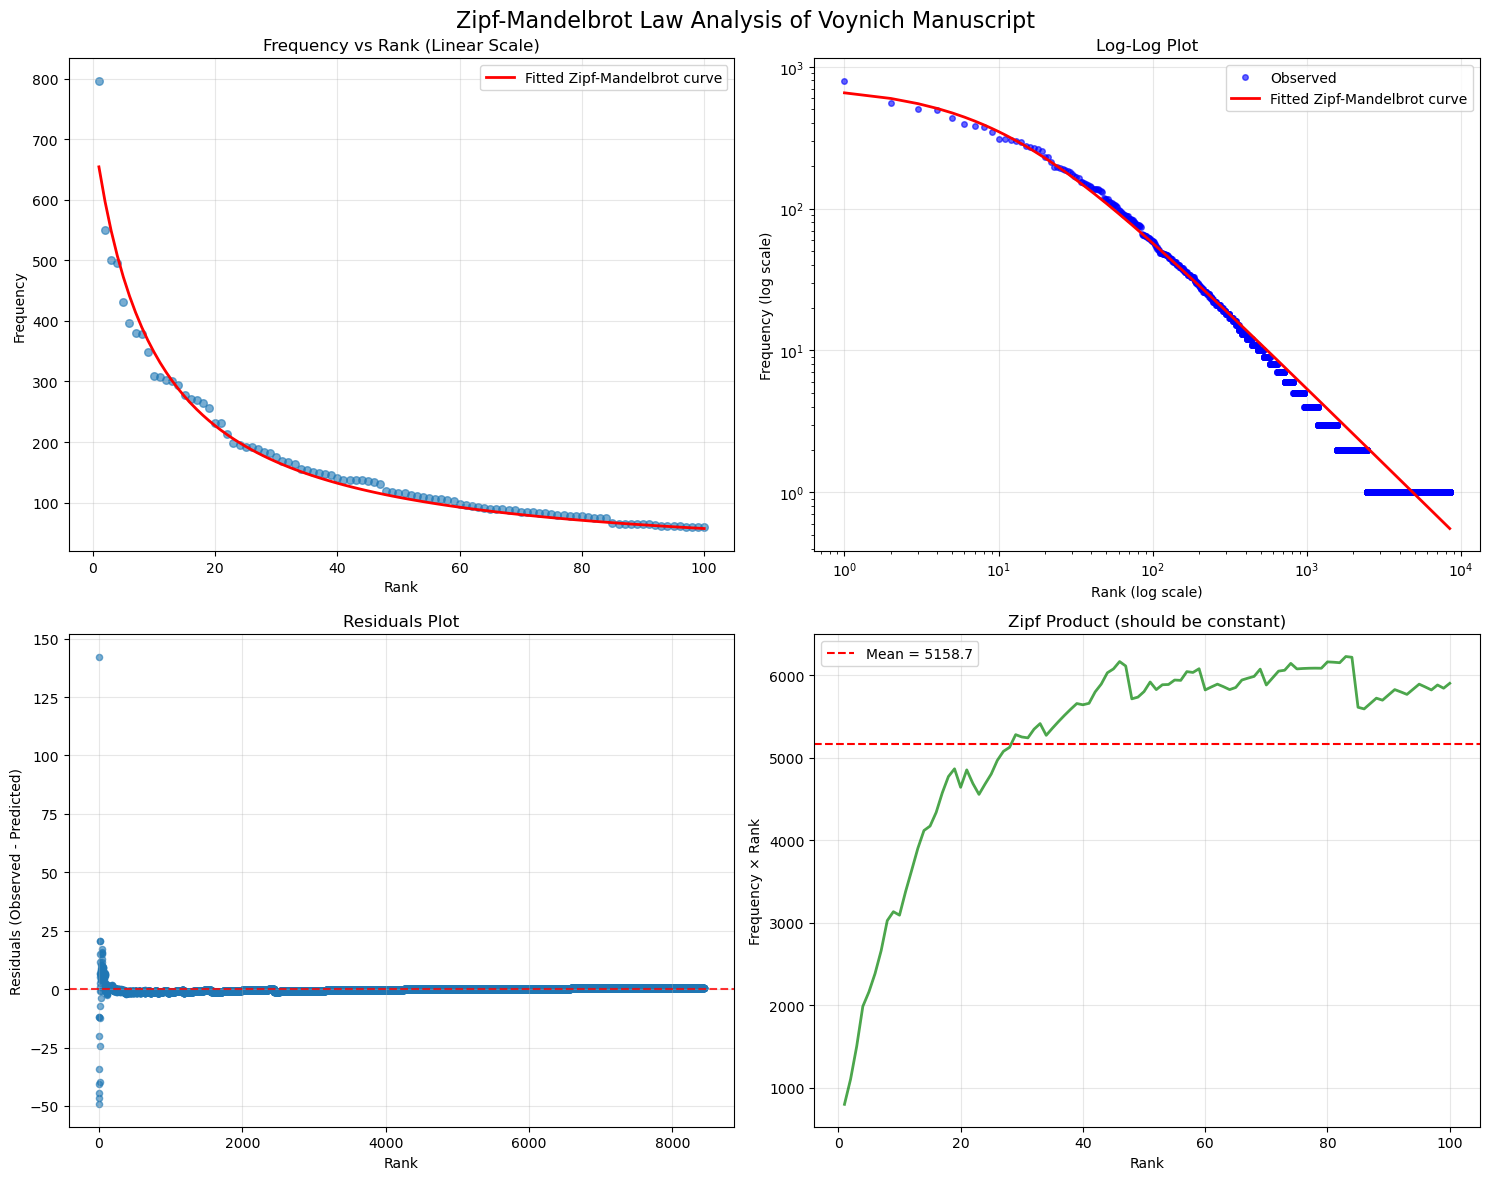

In [7]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

class VoynichZipfAnalyzer:
    def __init__(self, treat_commas_as_spaces=True):
        self.core_analyzer = CoreZipfAnalyzer()
        self.treat_commas_as_spaces = treat_commas_as_spaces
        self.tokens = []
        self.frequency_data = None
        self.zipf_results = {}
        self.cleaned_text = None
    
    def load_and_preprocess_text(self, filepath, treat_commas_as_spaces=True):
        """
        Load and clean the Voynich manuscript text.
        Returns cleaned text for use in other functions.
        """
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                lines = file.readlines()
            
            eva_text_segments = []
            
            for line in lines:
                line = line.strip()
                
                # Skip empty lines and comment lines
                if not line or line.startswith('#'):
                    continue
                
                # Look for lines that contain locus identifiers and extract EVA text
                match = re.match(r'<f[^>]+>\s*(.*)', line)
                if match:
                    eva_part = match.group(1).strip()
                    if eva_part:
                        processed_eva = self.process_eva_text(eva_part, treat_commas_as_spaces)
                        
                        if processed_eva:
                            eva_text_segments.append(processed_eva)
            
            final_text = ' '.join(eva_text_segments)
            self.cleaned_text = final_text
            return final_text
            
        except FileNotFoundError:
            return None
        except Exception as e:
            return None
    
    def process_eva_text(self, eva_text, treat_commas_as_spaces=True):
        """Helper method to process individual EVA text segments."""
        # Remove inline reference numbers like @254, @192
        eva_text = re.sub(r'@\d+', '', eva_text)
        
        # Remove complex comments like <!@254;>
        eva_text = re.sub(r'<![^>]*>', '', eva_text)
        
        # Remove other inline comments
        eva_text = re.sub(r'<[^>]*>', '', eva_text)
        
        # Handle uncertain readings [a:b:c] - keep first option
        def replace_uncertain(match):
            options = match.group(1).split(':')
            return options[0] if options else ''
        eva_text = re.sub(r'\[([^\]]+)\]', replace_uncertain, eva_text)
        
        # Remove ligature braces but keep content
        eva_text = re.sub(r'[{}]', '', eva_text)
        
        # Remove question marks (unreadable glyphs)
        eva_text = re.sub(r'\?+', '', eva_text)
        
        # Handle word boundaries - dots separate words in EVA
        if treat_commas_as_spaces:
            eva_text = eva_text.replace('.', ' ').replace(',', ' ')
        else:
            eva_text = eva_text.replace('.', ' ').replace(',', '')
        
        # Clean up whitespace and normalize case
        eva_text = re.sub(r'\s+', ' ', eva_text).strip()
        eva_text = eva_text.lower()
        
        # Filter out words that are not constituted with only letters
        words = eva_text.split()
        letter_only_words = []
        for word in words:
            if re.match(r'^[a-z]+$', word):
                letter_only_words.append(word)
        
        return ' '.join(letter_only_words)
    
    def apply_zipf_mandelbrot_analysis(self, text=None):
        """
        Apply Zipf-Mandelbrot law analysis to the text.
        If no text provided, uses previously loaded text.
        """
        if text is None:
            if self.cleaned_text is None:
                raise ValueError("No text provided and no text previously loaded")
            text = self.cleaned_text
        
        # Tokenize and calculate frequencies
        self.tokens = self.tokenize_text(text)
        self.frequency_data = self.calculate_frequencies()
        self.zipf_results = self.fit_zipf_mandelbrot_law()
        
        return self.zipf_results
    
    def tokenize_text(self, text):
        if text is None:
            return []
        
        tokens = text.split()
        tokens = [token for token in tokens if len(token) >= 1]
        return tokens
    
    def calculate_frequencies(self):
        self.frequency_data = self.core_analyzer.calculate_frequencies(self.tokens)
        return self.frequency_data
    
    def fit_zipf_mandelbrot_law(self):
        """
        Fit Zipf-Mandelbrot law: f(r) = C / (r + β)^α
        where C is a constant, β is the offset parameter, and α is the exponent
        """
        if self.frequency_data is None:
            return {}
        
        ranks = self.frequency_data['rank'].values
        frequencies = self.frequency_data['frequency'].values
        
        # Zipf-Mandelbrot function
        def zipf_mandelbrot(r, C, alpha, beta):
            return C / (r + beta) ** alpha
        
        try:
            # Initial parameter guesses
            initial_guess = [frequencies[0], 1.0, 10.0]
            
            # Fit the curve
            popt, pcov = curve_fit(zipf_mandelbrot, ranks, frequencies, 
                                 p0=initial_guess, maxfev=5000)
            
            C_opt, alpha_opt, beta_opt = popt
            
            # Calculate predicted frequencies
            predicted_freq = zipf_mandelbrot(ranks, C_opt, alpha_opt, beta_opt)
            
            # Calculate goodness of fit metrics
            ss_res = np.sum((frequencies - predicted_freq) ** 2)
            ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            
            rmse = np.sqrt(np.mean((frequencies - predicted_freq) ** 2))
            
            # Log-log regression for comparison
            log_ranks = np.log(ranks)
            log_frequencies = np.log(frequencies)
            
            # Remove any infinite or NaN values
            valid_idx = np.isfinite(log_ranks) & np.isfinite(log_frequencies)
            log_ranks_clean = log_ranks[valid_idx]
            log_frequencies_clean = log_frequencies[valid_idx]
            
            if len(log_ranks_clean) > 1:
                log_coeffs = np.polyfit(log_ranks_clean, log_frequencies_clean, 1)
                log_slope = log_coeffs[0]
                log_predicted = np.polyval(log_coeffs, log_ranks_clean)
                log_r_squared = 1 - np.sum((log_frequencies_clean - log_predicted) ** 2) / \
                               np.sum((log_frequencies_clean - np.mean(log_frequencies_clean)) ** 2)
            else:
                log_slope = np.nan
                log_r_squared = np.nan
            
            # Calculate frequency-rank products for Zipf analysis
            freq_rank_products = frequencies * ranks
            
            results = {
                'C': C_opt,
                'alpha': alpha_opt,
                'beta': beta_opt,
                'predicted_frequencies': predicted_freq,
                'r_squared': r_squared,
                'rmse': rmse,
                'log_slope': log_slope,
                'log_r_squared': log_r_squared,
                'parameter_errors': np.sqrt(np.diag(pcov)),
                'freq_rank_products': freq_rank_products
            }
            
            return results
            
        except Exception as e:
            print(f"Error fitting Zipf-Mandelbrot law: {e}")
            return {}
    
    def fit_zipf_law(self):
        """
        Maintained for backward compatibility - now calls Zipf-Mandelbrot
        """
        return self.fit_zipf_mandelbrot_law()
    
    def plot_zipf_analysis(self):
        if self.frequency_data is None or not self.zipf_results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Zipf-Mandelbrot Law Analysis of Voynich Manuscript', fontsize=16)
        
        ranks = self.frequency_data['rank'].values
        frequencies = self.frequency_data['frequency'].values
        predicted_freq = self.zipf_results['predicted_frequencies']
        
        # Plot 1: Linear scale
        axes[0, 0].scatter(ranks[:100], frequencies[:100], alpha=0.6, s=30)
        axes[0, 0].plot(ranks[:100], predicted_freq[:100], 'r-', linewidth=2, label='Fitted Zipf-Mandelbrot curve')
        axes[0, 0].set_xlabel('Rank')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Frequency vs Rank (Linear Scale)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Log-log plot
        axes[0, 1].loglog(ranks, frequencies, 'bo', alpha=0.6, markersize=4, label='Observed')
        axes[0, 1].loglog(ranks, predicted_freq, 'r-', linewidth=2, label='Fitted Zipf-Mandelbrot curve')
        axes[0, 1].set_xlabel('Rank (log scale)')
        axes[0, 1].set_ylabel('Frequency (log scale)')
        axes[0, 1].set_title('Log-Log Plot')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Residuals
        residuals = frequencies - predicted_freq
        axes[1, 0].scatter(ranks, residuals, alpha=0.6, s=20)
        axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
        axes[1, 0].set_xlabel('Rank')
        axes[1, 0].set_ylabel('Residuals (Observed - Predicted)')
        axes[1, 0].set_title('Residuals Plot')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Frequency rank product
        freq_rank_products = self.zipf_results['freq_rank_products']
        axes[1, 1].plot(ranks[:100], freq_rank_products[:100], 'g-', alpha=0.7, linewidth=2)
        axes[1, 1].axhline(y=np.mean(freq_rank_products), color='r', linestyle='--', 
                          label=f'Mean = {np.mean(freq_rank_products):.1f}')
        axes[1, 1].set_xlabel('Rank')
        axes[1, 1].set_ylabel('Frequency × Rank')
        axes[1, 1].set_title('Zipf Product (should be constant)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

voynich_analyzer = VoynichZipfAnalyzer(treat_commas_as_spaces=True)

# Load and clean the text
text = voynich_analyzer.load_and_preprocess_text("transliteration_zl.txt")

if text is not None:
    # Apply Zipf-Mandelbrot analysis
    zipf_results = voynich_analyzer.apply_zipf_mandelbrot_analysis()
    metrics = voynich_analyzer.core_analyzer.calculate_language_metrics()
    
    # Create Voynich results DataFrame
    voynich_df = pd.DataFrame({
        'Language': ['Voynich Manuscript'],
        'Type': ['Unknown'],
        'Total_Tokens': [metrics['total_tokens']],
        'Unique_Tokens': [metrics['unique_tokens']],
        'Type_Token_Ratio': [metrics['type_token_ratio']],
        'Hapax_Ratio': [metrics['hapax_ratio']],
        'Zipf_C': [zipf_results['C']],
        'Zipf_Alpha': [zipf_results['alpha']],
        'Zipf_Beta': [zipf_results['beta']],
        'R_Squared': [zipf_results['r_squared']],
        'RMSE': [zipf_results['rmse']],
        'Log_Slope': [zipf_results['log_slope']],
        'Log_R_Squared': [zipf_results['log_r_squared']]
    })
    
    # Display results
    print("Voynich Zipf-Mandelbrot Analysis Results:")
    print(f"C (constant): {zipf_results['C']:.2f}")
    print(f"α (exponent): {zipf_results['alpha']:.2f}")
    print(f"β (offset): {zipf_results['beta']:.2f}")
    print(f"R²: {zipf_results['r_squared']:.4f}")
    print(f"RMSE: {zipf_results['rmse']:.4f}")
    display(voynich_df)
    
    # Show plots
    voynich_analyzer.plot_zipf_analysis()
    
else:
    print("Could not load Voynich file 'transliteration_zl.txt'")
    voynich_df

In [8]:
class LanguageCorpusAnalyzer:
    def __init__(self, natural_corpus_dir="language_corpora", constructed_corpus_dir="constructed_language_corpora"):
        self.corpus_dirs = [Path(natural_corpus_dir), Path(constructed_corpus_dir)]
        self.language_results = {}
        self.core_analyzer = CoreZipfAnalyzer()
    
    def analyze_language_corpus(self, text, language_name):
        results = self.core_analyzer.analyze_text(text, language_name)
        
        if results is None:
            return None
        
        zipf_results = results['zipf_results']
        metrics = results['metrics']
        
        return {
            'language': language_name,
            'total_tokens': metrics['total_tokens'],
            'unique_tokens': metrics['unique_tokens'],
            'type_token_ratio': metrics['type_token_ratio'],
            'hapax_ratio': metrics['hapax_ratio'],
            'zipf_C': zipf_results['C'],
            'zipf_alpha': zipf_results['alpha'],
            'r_squared': zipf_results['r_squared'],
            'rmse': zipf_results['rmse'],
            'log_slope': zipf_results['log_slope'],
            'log_r_squared': zipf_results['log_r_squared'],
            'frequency_data': results['frequency_data'],
            'predicted_frequencies': zipf_results['predicted_frequencies'],
            'top_10_words': results['top_10_words']
        }
    
    def analyze_all_languages(self):
        corpus_files = []
        for corpus_dir in self.corpus_dirs:
            corpus_files.extend(list(corpus_dir.glob("*_corpus.txt")))
        
        if not corpus_files:
            return None, None
        
        successful_results = []
        
        for corpus_file in corpus_files:
            language_name = corpus_file.stem.replace('_corpus', '')
            
            try:
                with open(corpus_file, 'r', encoding='utf-8') as f:
                    text = f.read()
                
                results = self.analyze_language_corpus(text, language_name.title())
                
                if results:
                    successful_results.append(results)
                    self.language_results[language_name] = results
                    
            except Exception as e:
                continue
        
        if not successful_results:
            return None, None
        
        # Create languages results DataFrame
        languages_df = pd.DataFrame([
            {
                'Language': result['language'],
                'Type': 'Natural' if 'language_corpora' in str(corpus_file) else 'Constructed',
                'Total_Tokens': result['total_tokens'],
                'Unique_Tokens': result['unique_tokens'],
                'Type_Token_Ratio': result['type_token_ratio'],
                'Hapax_Ratio': result['hapax_ratio'],
                'Zipf_C': result['zipf_C'],
                'Zipf_Alpha': result['zipf_alpha'],
                'R_Squared': result['r_squared'],
                'RMSE': result['rmse'],
                'Log_Slope': result['log_slope'],
                'Log_R_Squared': result['log_r_squared']
            }
            for result in successful_results
        ])
        
        # Create language statistics DataFrame
        stats_df = pd.DataFrame({
            'Metric': ['Zipf_Alpha', 'R_Squared', 'Type_Token_Ratio', 'Hapax_Ratio'],
            'Mean': [
                languages_df['Zipf_Alpha'].mean(),
                languages_df['R_Squared'].mean(),
                languages_df['Type_Token_Ratio'].mean(),
                languages_df['Hapax_Ratio'].mean()
            ],
            'Std': [
                languages_df['Zipf_Alpha'].std(),
                languages_df['R_Squared'].std(),
                languages_df['Type_Token_Ratio'].std(),
                languages_df['Hapax_Ratio'].std()
            ],
            'Min': [
                languages_df['Zipf_Alpha'].min(),
                languages_df['R_Squared'].min(),
                languages_df['Type_Token_Ratio'].min(),
                languages_df['Hapax_Ratio'].min()
            ],
            'Max': [
                languages_df['Zipf_Alpha'].max(),
                languages_df['R_Squared'].max(),
                languages_df['Type_Token_Ratio'].max(),
                languages_df['Hapax_Ratio'].max()
            ]
        })
        
        return languages_df, stats_df

# Analyze all language corpora
language_analyzer = LanguageCorpusAnalyzer()
languages_df, language_stats_df = language_analyzer.analyze_all_languages()

if languages_df is not None:
    print(f"Analyzed {len(languages_df)} languages successfully")
    
    print("\nLanguage Analysis Results:")
    display(languages_df)
    
    print("\nLanguage Statistics:")
    display(language_stats_df)
    
else:
    print("No language corpora found or analysis failed")
    languages_df = None
    language_stats_df = None

Analyzed 22 languages successfully

Language Analysis Results:


,Language,Type,Total_Tokens,Unique_Tokens,Type_Token_Ratio,Hapax_Ratio,Zipf_C,Zipf_Alpha,R_Squared,RMSE,Log_Slope,Log_R_Squared
0,Albanian,Natural,14454,4337,0.300055,0.577127,882.082168,0.850092,0.984584,2.370849,-0.761390,0.951824
1,Arabic,Natural,56729,13842,0.244002,0.602153,2045.552761,0.787424,0.956468,5.648974,-0.881573,0.952587
2,Basque,Natural,12840,5248,0.408723,0.697980,570.094872,0.889387,0.934753,2.934898,-0.677861,0.914572
3,Bulgarian,Natural,5614,2703,0.481475,0.736589,328.488722,0.960781,0.966836,1.741753,-0.594247,0.890205
4,English,Natural,74877,8976,0.119877,0.435272,5224.247800,0.878041,0.976551,11.989786,-1.092042,0.971649
5,Finnish,Natural,29442,10295,0.349671,0.528023,1284.152561,0.953803,0.970033,3.202702,-0.702839,0.951590
6,French,Natural,75890,11406,0.150296,0.545765,4996.868336,0.837074,0.968824,12.561773,-0.986723,0.966992
7,German,Natural,38793,9744,0.251179,0.639265,1804.995855,0.778384,0.951222,6.593549,-0.817479,0.941401
8,Greek,Natural,39081,9588,0.245337,0.563830,1825.747227,0.769980,0.932201,8.089085,-0.811548,0.957920
9,Hebrew,Natural,9870,4778,0.484093,0.700502,247.916346,0.724867,0.960479,1.179244,-0.613741,0.911967



Language Statistics:


,Metric,Mean,Std,Min,Max
0,Zipf_Alpha,0.827659,0.112938,0.662343,1.100503
1,R_Squared,0.962839,0.017083,0.931293,0.992241
2,Type_Token_Ratio,0.313680,0.111376,0.119877,0.492227
3,Hapax_Ratio,0.619238,0.080774,0.435272,0.737422


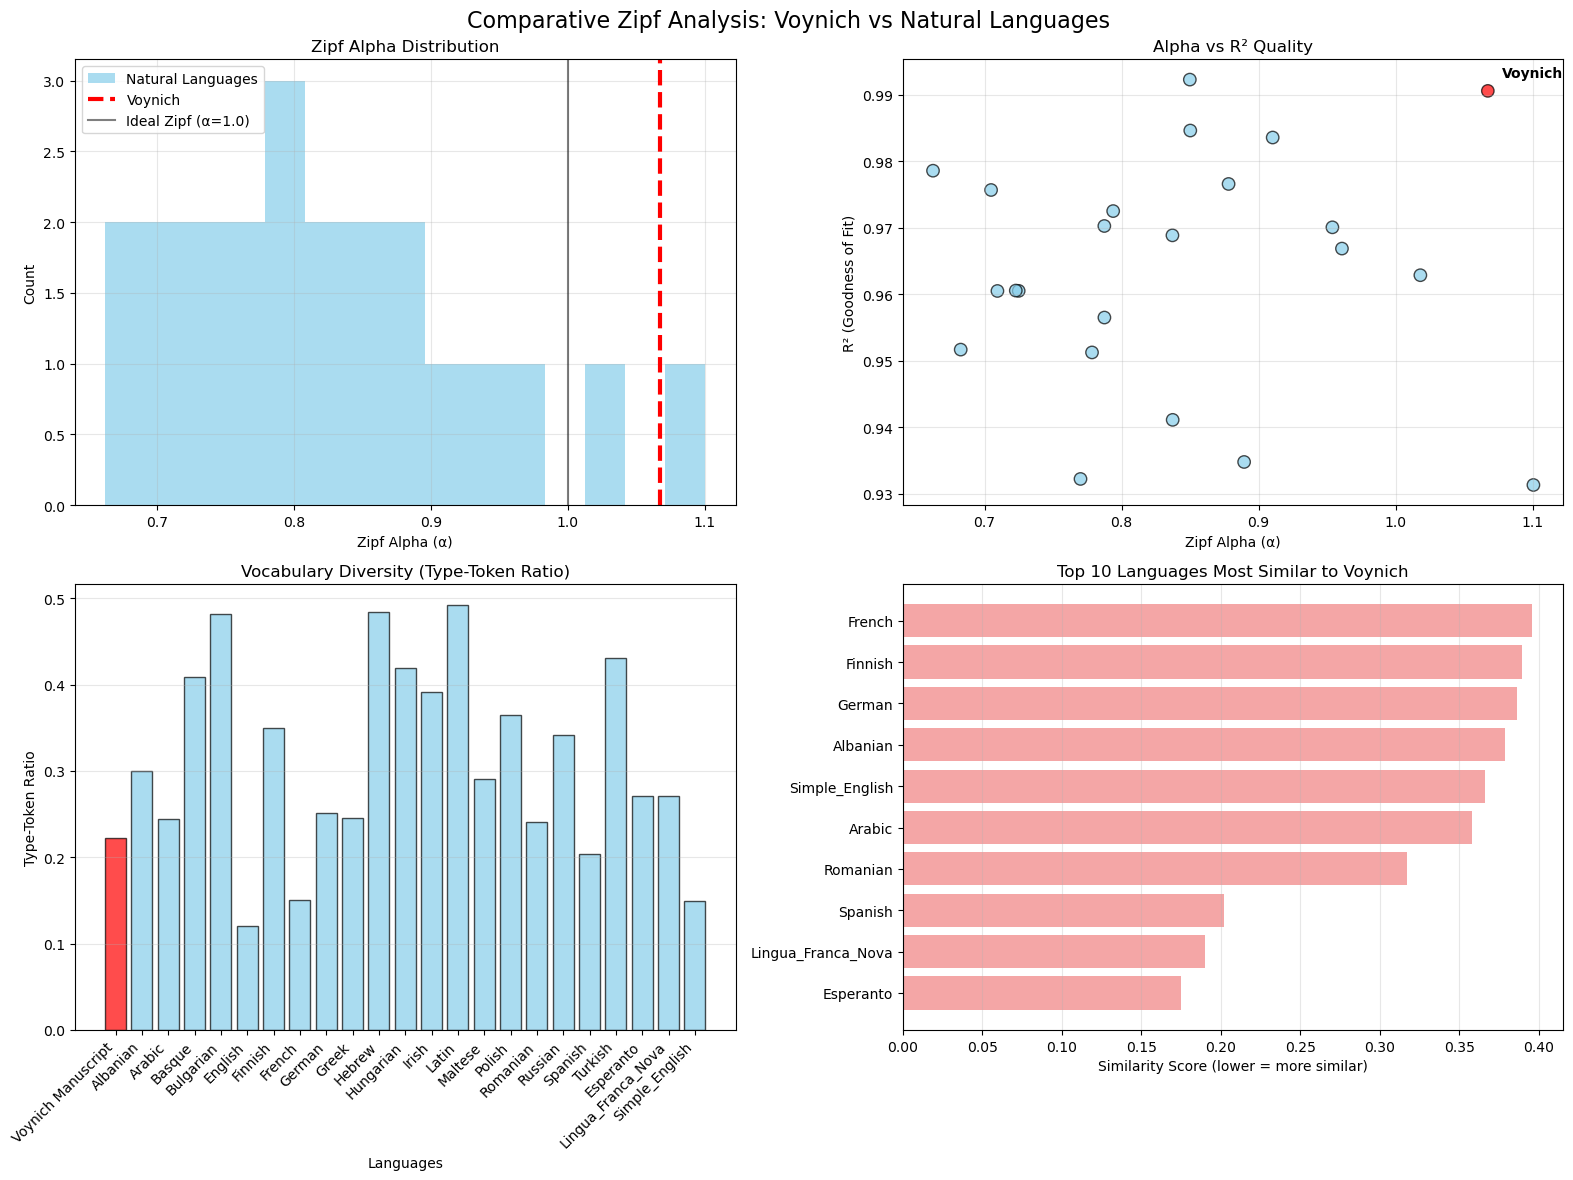

Combined Results (Voynich + All Languages):


,Language,Type,Total_Tokens,Unique_Tokens,Type_Token_Ratio,Hapax_Ratio,Zipf_C,Zipf_Alpha,Zipf_Beta,R_Squared,RMSE,Log_Slope,Log_R_Squared
0,Voynich Manuscript,Unknown,38002,8442,0.222146,0.710495,8617.867400,1.067241,10.190708,0.990546,2.198545,-0.881681,0.902885
1,Albanian,Natural,14454,4337,0.300055,0.577127,882.082168,0.850092,NaN,0.984584,2.370849,-0.761390,0.951824
2,Arabic,Natural,56729,13842,0.244002,0.602153,2045.552761,0.787424,NaN,0.956468,5.648974,-0.881573,0.952587
3,Basque,Natural,12840,5248,0.408723,0.697980,570.094872,0.889387,NaN,0.934753,2.934898,-0.677861,0.914572
4,Bulgarian,Natural,5614,2703,0.481475,0.736589,328.488722,0.960781,NaN,0.966836,1.741753,-0.594247,0.890205
5,English,Natural,74877,8976,0.119877,0.435272,5224.247800,0.878041,NaN,0.976551,11.989786,-1.092042,0.971649
6,Finnish,Natural,29442,10295,0.349671,0.528023,1284.152561,0.953803,NaN,0.970033,3.202702,-0.702839,0.951590
7,French,Natural,75890,11406,0.150296,0.545765,4996.868336,0.837074,NaN,0.968824,12.561773,-0.986723,0.966992
8,German,Natural,38793,9744,0.251179,0.639265,1804.995855,0.778384,NaN,0.951222,6.593549,-0.817479,0.941401
9,Greek,Natural,39081,9588,0.245337,0.563830,1825.747227,0.769980,NaN,0.932201,8.089085,-0.811548,0.957920



Language Similarity to Voynich (All Languages):


,Language,Similarity_Score,Alpha_Difference,R2_Difference,TTR_Difference,Zipf_Alpha,R_Squared,Type_Token_Ratio
19,Esperanto,0.175101,0.049241,0.027712,0.049074,1.018000,0.962834,0.271220
20,Lingua_Franca_Nova,0.189662,0.033262,0.059253,0.048574,1.100503,0.931293,0.270720
17,Spanish,0.201735,0.157011,0.007013,0.018856,0.910230,0.983533,0.203291
15,Romanian,0.316877,0.229998,0.049461,0.018709,0.837243,0.941085,0.240856
1,Arabic,0.357607,0.279817,0.034078,0.021856,0.787424,0.956468,0.244002
21,Simple_English,0.365857,0.217473,0.001695,0.073344,0.849768,0.992241,0.148802
0,Albanian,0.378929,0.217149,0.005962,0.077909,0.850092,0.984584,0.300055
7,German,0.386248,0.288858,0.039324,0.029033,0.778384,0.951222,0.251179
5,Finnish,0.389000,0.113438,0.020513,0.127524,0.953803,0.970033,0.349671
6,French,0.395588,0.230167,0.021722,0.071850,0.837074,0.968824,0.150296



Language Fit Quality Rankings (All Languages):


,Language,Zipf_Alpha,R_Squared,RMSE,Type_Token_Ratio
21,Simple_English,0.849768,0.992241,3.930358,0.148802
0,Albanian,0.850092,0.984584,2.370849,0.300055
17,Spanish,0.910230,0.983533,6.077058,0.203291
16,Russian,0.662343,0.978545,1.560035,0.341534
4,English,0.878041,0.976551,11.989786,0.119877
18,Turkish,0.704720,0.975644,1.082393,0.431098
11,Irish,0.793823,0.972475,1.597695,0.391693
10,Hungarian,0.787369,0.970230,1.669505,0.419032
5,Finnish,0.953803,0.970033,3.202702,0.349671
6,French,0.837074,0.968824,12.561773,0.150296



Voynich vs Natural Language Comparison:


,Metric,Voynich_Value,Natural_Mean,Natural_Min,Natural_Max,Percentile
0,Zipf_Alpha,1.067241,0.827659,0.662343,1.100503,95.454545
1,R_Squared,0.990546,0.962839,0.931293,0.992241,95.454545
2,Type_Token_Ratio,0.222146,0.313680,0.119877,0.492227,18.181818
3,Hapax_Ratio,0.710495,0.619238,0.435272,0.737422,90.909091


In [9]:
# Combine and compare all results
if voynich_df is not None and languages_df is not None:
    
    # Combined results DataFrame (Voynich + all languages)
    combined_df = pd.concat([voynich_df, languages_df], ignore_index=True)
    
    # Similarity DataFrame (all languages ranked by similarity to Voynich)
    voynich_alpha = voynich_df['Zipf_Alpha'].iloc[0]
    voynich_r2 = voynich_df['R_Squared'].iloc[0]
    voynich_ttr = voynich_df['Type_Token_Ratio'].iloc[0]
    
    similarity_scores = []
    for _, lang in languages_df.iterrows():
        alpha_diff = abs(lang['Zipf_Alpha'] - voynich_alpha)
        r2_diff = abs(lang['R_Squared'] - voynich_r2)
        ttr_diff = abs(lang['Type_Token_Ratio'] - voynich_ttr)
        
        similarity_score = alpha_diff + r2_diff + (ttr_diff * 2)
        
        similarity_scores.append({
            'Language': lang['Language'],
            'Similarity_Score': similarity_score,
            'Alpha_Difference': alpha_diff,
            'R2_Difference': r2_diff,
            'TTR_Difference': ttr_diff,
            'Zipf_Alpha': lang['Zipf_Alpha'],
            'R_Squared': lang['R_Squared'],
            'Type_Token_Ratio': lang['Type_Token_Ratio']
        })
    
    similarity_df = pd.DataFrame(similarity_scores).sort_values('Similarity_Score')
    
    # Fit quality DataFrame (all languages ranked by R²)
    fit_quality_df = languages_df[['Language', 'Zipf_Alpha', 'R_Squared', 'RMSE', 'Type_Token_Ratio']].sort_values('R_Squared', ascending=False)
    
    # Comparison statistics DataFrame
    comparison_stats_df = pd.DataFrame({
        'Metric': ['Zipf_Alpha', 'R_Squared', 'Type_Token_Ratio', 'Hapax_Ratio'],
        'Voynich_Value': [
            voynich_df['Zipf_Alpha'].iloc[0],
            voynich_df['R_Squared'].iloc[0],
            voynich_df['Type_Token_Ratio'].iloc[0],
            voynich_df['Hapax_Ratio'].iloc[0]
        ],
        'Natural_Mean': [
            languages_df['Zipf_Alpha'].mean(),
            languages_df['R_Squared'].mean(),
            languages_df['Type_Token_Ratio'].mean(),
            languages_df['Hapax_Ratio'].mean()
        ],
        'Natural_Min': [
            languages_df['Zipf_Alpha'].min(),
            languages_df['R_Squared'].min(),
            languages_df['Type_Token_Ratio'].min(),
            languages_df['Hapax_Ratio'].min()
        ],
        'Natural_Max': [
            languages_df['Zipf_Alpha'].max(),
            languages_df['R_Squared'].max(),
            languages_df['Type_Token_Ratio'].max(),
            languages_df['Hapax_Ratio'].max()
        ],
        'Percentile': [
            (languages_df['Zipf_Alpha'] < voynich_alpha).mean() * 100,
            (languages_df['R_Squared'] < voynich_r2).mean() * 100,
            (languages_df['Type_Token_Ratio'] < voynich_ttr).mean() * 100,
            (languages_df['Hapax_Ratio'] < voynich_df['Hapax_Ratio'].iloc[0]).mean() * 100
        ]
    })
    
    # Create comparative visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparative Zipf Analysis: Voynich vs Natural Languages', fontsize=16)
    
    # Plot data preparation
    all_languages = combined_df['Language'].tolist()
    all_alphas = combined_df['Zipf_Alpha'].tolist()
    all_r2s = combined_df['R_Squared'].tolist()
    all_ttrs = combined_df['Type_Token_Ratio'].tolist()
    colors = ['red' if lang == 'Voynich Manuscript' else 'skyblue' for lang in all_languages]
    
    # Plot 1: Alpha distribution
    ax1 = axes[0, 0]
    natural_alphas = languages_df['Zipf_Alpha'].tolist()
    ax1.hist(natural_alphas, bins=15, alpha=0.7, color='skyblue', label='Natural Languages')
    ax1.axvline(voynich_alpha, color='red', linestyle='--', linewidth=3, label='Voynich')
    ax1.axvline(1.0, color='black', linestyle='-', alpha=0.5, label='Ideal Zipf (α=1.0)')
    ax1.set_xlabel('Zipf Alpha (α)')
    ax1.set_ylabel('Count')
    ax1.set_title('Zipf Alpha Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Alpha vs R² scatter
    ax2 = axes[0, 1]
    scatter = ax2.scatter(all_alphas, all_r2s, c=colors, s=80, alpha=0.7, edgecolors='black')
    ax2.set_xlabel('Zipf Alpha (α)')
    ax2.set_ylabel('R² (Goodness of Fit)')
    ax2.set_title('Alpha vs R² Quality')
    ax2.annotate('Voynich', (voynich_alpha, voynich_r2), xytext=(10, 10), 
                textcoords='offset points', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Type-Token Ratio comparison
    ax3 = axes[1, 0]
    bars = ax3.bar(range(len(all_languages)), all_ttrs, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Languages')
    ax3.set_ylabel('Type-Token Ratio')
    ax3.set_title('Vocabulary Diversity (Type-Token Ratio)')
    ax3.set_xticks(range(len(all_languages)))
    ax3.set_xticklabels(all_languages, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Similarity ranking (top 10)
    ax4 = axes[1, 1]
    top_similar = similarity_df.head(10)
    sim_names = top_similar['Language'].tolist()
    sim_scores = top_similar['Similarity_Score'].tolist()
    
    bars = ax4.barh(range(len(sim_names)), sim_scores, color='lightcoral', alpha=0.7)
    ax4.set_yticks(range(len(sim_names)))
    ax4.set_yticklabels(sim_names)
    ax4.set_xlabel('Similarity Score (lower = more similar)')
    ax4.set_title('Top 10 Languages Most Similar to Voynich')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("Combined Results (Voynich + All Languages):")
    display(combined_df)
    
    print("\nLanguage Similarity to Voynich (All Languages):")
    display(similarity_df)
    
    print("\nLanguage Fit Quality Rankings (All Languages):")
    display(fit_quality_df)
    
    print("\nVoynich vs Natural Language Comparison:")
    display(comparison_stats_df)

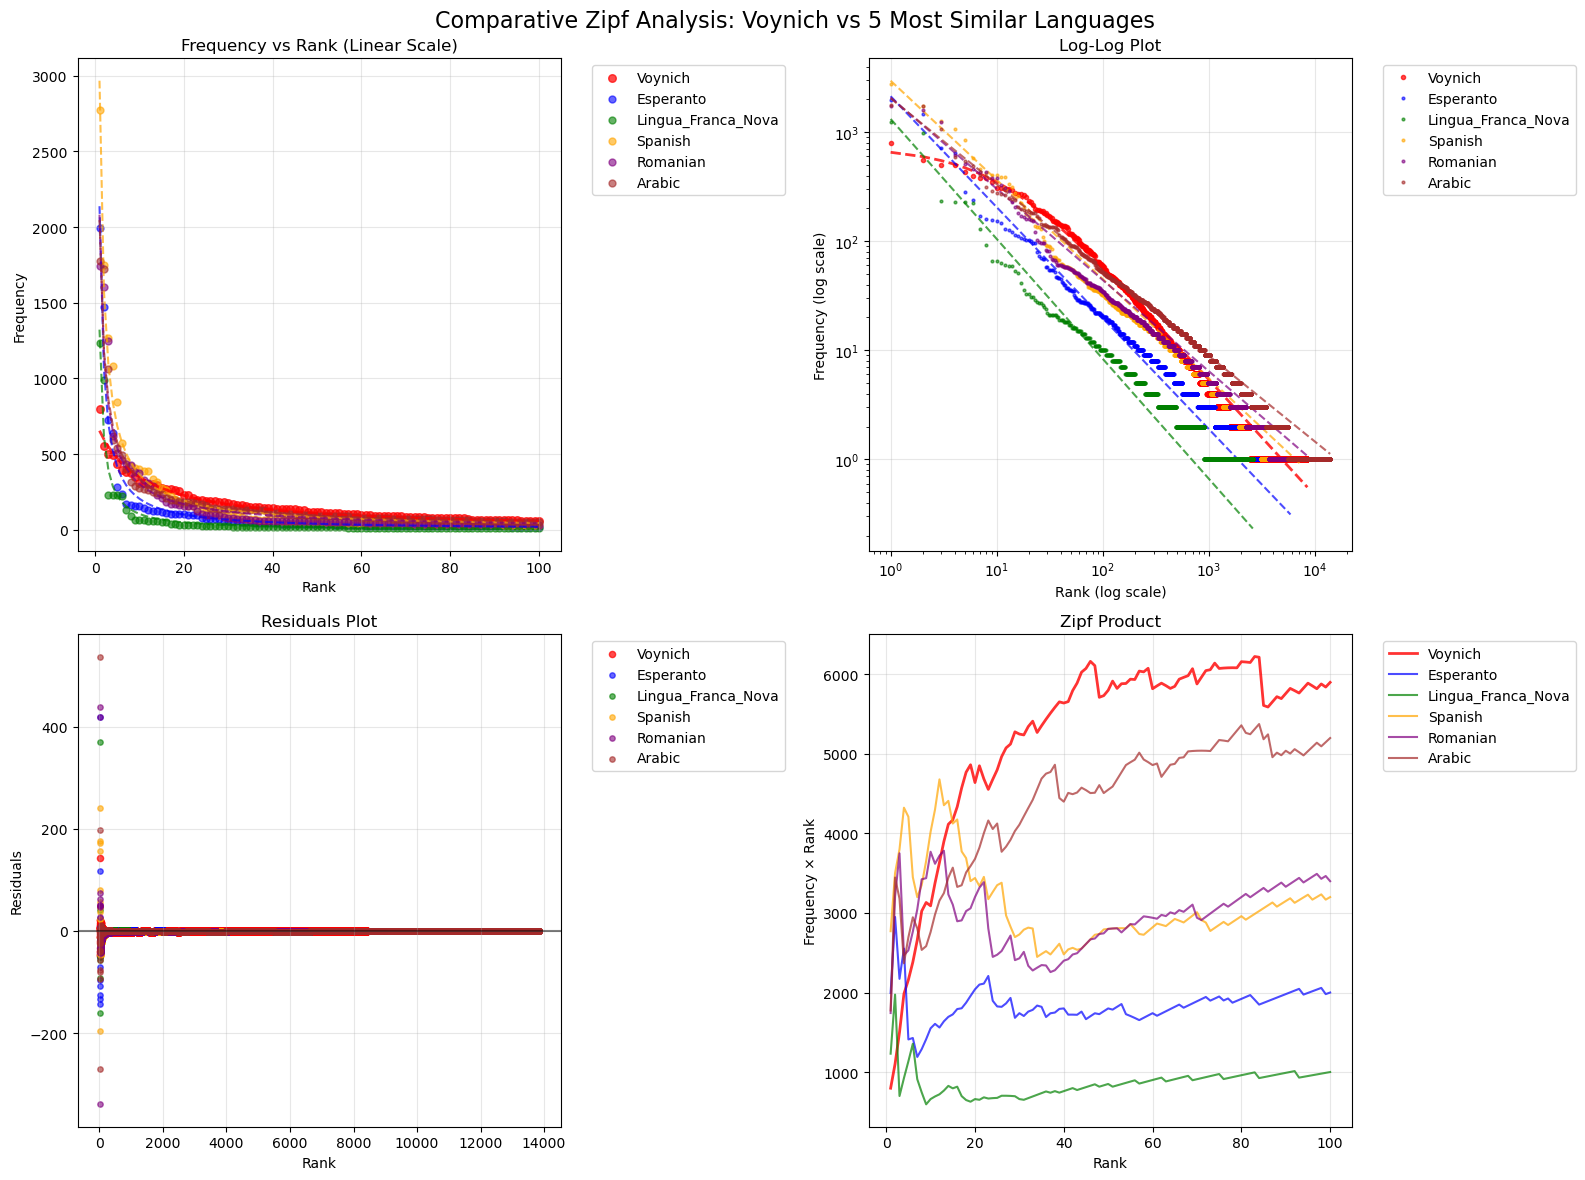

Languages in comparison:


,Language,Zipf_Alpha,R_Squared,Type_Token_Ratio,Similarity_Score
0,Voynich,1.067241,0.990546,0.222146,0.000000
1,Esperanto,1.018000,0.962834,0.271220,0.175101
2,Lingua_Franca_Nova,1.100503,0.931293,0.270720,0.189662
3,Spanish,0.910230,0.983533,0.203291,0.201735
4,Romanian,0.837243,0.941085,0.240856,0.316877
5,Arabic,0.787424,0.956468,0.244002,0.357607


In [10]:
# Create comparative plots showing Voynich vs 5 most similar languages on the same axes
if similarity_df is not None and language_analyzer.language_results:
    
    # Get the 5 most similar languages
    top_5_similar = similarity_df.head(5)
    
    # Set up colors for different languages
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    # Create the 4-panel comparative plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparative Zipf Analysis: Voynich vs 5 Most Similar Languages', fontsize=16)
    
    # First plot Voynich (red)
    voynich_freq_data = voynich_analyzer.frequency_data
    voynich_predicted = voynich_analyzer.zipf_results['predicted_frequencies']
    voynich_ranks = voynich_freq_data['rank'].values
    voynich_frequencies = voynich_freq_data['frequency'].values
    
    # Plot 1: Linear scale frequency vs rank
    axes[0, 0].scatter(voynich_ranks[:100], voynich_frequencies[:100], 
                      alpha=0.7, s=30, color=colors[0], label='Voynich')
    axes[0, 0].plot(voynich_ranks[:100], voynich_predicted[:100], 
                   color=colors[0], linewidth=2, linestyle='--', alpha=0.8)
    
    # Plot 2: Log-log plot
    axes[0, 1].loglog(voynich_ranks, voynich_frequencies, 'o', 
                     alpha=0.7, markersize=3, color=colors[0], label='Voynich')
    axes[0, 1].loglog(voynich_ranks, voynich_predicted, 
                     color=colors[0], linewidth=2, linestyle='--', alpha=0.8)
    
    # Plot 3: Residuals
    voynich_residuals = voynich_frequencies - voynich_predicted
    axes[1, 0].scatter(voynich_ranks, voynich_residuals, 
                      alpha=0.7, s=20, color=colors[0], label='Voynich')
    
    # Plot 4: Frequency rank product
    voynich_products = voynich_freq_data['frequency'] * voynich_freq_data['rank']
    axes[1, 1].plot(voynich_ranks[:100], voynich_products[:100], 
                   color=colors[0], alpha=0.8, linewidth=2, label='Voynich')
    
    # 5 most similar languages
    for i, (_, row) in enumerate(top_5_similar.iterrows(), 1):
        language_name = row['Language']
        language_key = language_name.lower()
        
        if language_key in language_analyzer.language_results:
            lang_results = language_analyzer.language_results[language_key]
            
            freq_data = lang_results['frequency_data']
            predicted_freq = lang_results['predicted_frequencies']
            ranks = freq_data['rank'].values
            frequencies = freq_data['frequency'].values
            
            # Plot 1: Linear scale
            axes[0, 0].scatter(ranks[:100], frequencies[:100], 
                              alpha=0.6, s=25, color=colors[i], label=language_name)
            axes[0, 0].plot(ranks[:100], predicted_freq[:100], 
                           color=colors[i], linewidth=1.5, linestyle='--', alpha=0.7)
            
            # Plot 2: Log-log plot
            axes[0, 1].loglog(ranks, frequencies, 'o', 
                             alpha=0.6, markersize=2, color=colors[i], label=language_name)
            axes[0, 1].loglog(ranks, predicted_freq, 
                             color=colors[i], linewidth=1.5, linestyle='--', alpha=0.7)
            
            # Plot 3: Residuals
            residuals = frequencies - predicted_freq
            axes[1, 0].scatter(ranks, residuals, 
                              alpha=0.6, s=15, color=colors[i], label=language_name)
            
            # Plot 4: Frequency rank product
            products = freq_data['frequency'] * freq_data['rank']
            axes[1, 1].plot(ranks[:100], products[:100], 
                           color=colors[i], alpha=0.7, linewidth=1.5, label=language_name)
    
    # Customize plots
    axes[0, 0].set_xlabel('Rank')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Frequency vs Rank (Linear Scale)')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_xlabel('Rank (log scale)')
    axes[0, 1].set_ylabel('Frequency (log scale)')
    axes[0, 1].set_title('Log-Log Plot')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_xlabel('Rank')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Frequency × Rank')
    axes[1, 1].set_title('Zipf Product')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show the comparison metrics
    print("Languages in comparison:")
    comparison_metrics = pd.DataFrame({
        'Language': ['Voynich'] + top_5_similar['Language'].tolist(),
        'Zipf_Alpha': [voynich_df['Zipf_Alpha'].iloc[0]] + top_5_similar['Zipf_Alpha'].tolist(),
        'R_Squared': [voynich_df['R_Squared'].iloc[0]] + top_5_similar['R_Squared'].tolist(),
        'Type_Token_Ratio': [voynich_df['Type_Token_Ratio'].iloc[0]] + top_5_similar['Type_Token_Ratio'].tolist(),
        'Similarity_Score': [0.0] + top_5_similar['Similarity_Score'].tolist()
    })
    
    display(comparison_metrics)

#### Funtional Words

Functional words, or grammatical words, are small but essential elements like articles (the, a), prepositions (in, on, with), pronouns (he, she, it), and conjunctions (and, but, or) that primarily serve grammatical purposes rather than carrying concrete meaning. Unlike *content words* (nouns, verbs, adjectives) that convey the main semantic information, functional words act as the structural glue that binds sentences together and indicates relationships between ideas. 

In language decipherment, functional words are particularly valuable because they appear with high frequency, follow predictable grammatical patterns, and often have cognates across related languages, making them reliable anchor points for scholars attempting to decode unknown scripts or languages—much like how archaeologists use pottery sherds to date and understand ancient cultures.

In [11]:
# Import Libs
from collections import Counter
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import math

In [12]:
# Core entropy functions
def conditional_entropy(tokens, word):
    if not tokens or word not in tokens:
        return 0
    word_positions = [i for i, token in enumerate(tokens) if token == word]
    if len(word_positions) < 2:
        return 0
    
    contexts = [tokens[pos + 1] for pos in word_positions if pos + 1 < len(tokens)]
    if not contexts:
        return 0
    
    context_counter = Counter(contexts)
    total_contexts = len(contexts)
    entropy = sum(-(count/total_contexts) * math.log2(count/total_contexts) 
                  for count in context_counter.values())
    return entropy

# Configuration
LANGS = ["english", "arabic", "german", "hungarian", "finnish", "romanian", "russian"]
TOP_N = 50
COLS = ["voynich"] + LANGS

# Get tokens function
def get_tokens_for_language(lang_name):
    if lang_name == "voynich":
        if 'voynich_analyzer' in globals() and hasattr(voynich_analyzer, 'tokens'):
            return voynich_analyzer.tokens
    else:
        if 'language_analyzer' in globals() and hasattr(language_analyzer, 'language_results'):
            lang_key = lang_name.lower()
            if lang_key in language_analyzer.language_results:
                freq_data = language_analyzer.language_results[lang_key]['frequency_data']
                tokens = []
                for _, row in freq_data.iterrows():
                    tokens.extend([row['token']] * row['frequency'])
                return tokens
    return []

# Load stopwords
nltk.download("stopwords", quiet=True)
stopsets = {}
for lang in LANGS:
    try:
        stopsets[lang] = set(stopwords.words(lang))
    except:
        stopsets[lang] = set()
stopsets["voynich"] = set()

# Calculate entropy data and build frequency lists
entropy_analysis = {}
top_lists = {}

for col in COLS:
    tokens = get_tokens_for_language(col)
    if tokens:
        total = len(tokens)
        counter = Counter(tokens)
        most_common = counter.most_common(TOP_N)
        
        # Entropy analysis
        word_entropies = {word: conditional_entropy(tokens, word) for word, count in most_common}
        avg_cond_entropy = np.mean(list(word_entropies.values())) if word_entropies else 0
        
        entropy_analysis[col] = {
            'word_entropies': word_entropies,
            'avg_conditional_entropy': avg_cond_entropy
        }
        
        # Frequency lists
        top_lists[col] = [(word, (count/total)*100) for word, count in most_common]
    else:
        entropy_analysis[col] = {'word_entropies': {}, 'avg_conditional_entropy': 0}
        top_lists[col] = []

# Build DataFrame
data = {}
for col in COLS:
    rows = []
    for i in range(TOP_N):
        if i < len(top_lists.get(col, [])):
            word, pct = top_lists[col][i]
            rows.append(f"{word}\n{pct:.3f}%")
        else:
            rows.append("")
    data[col] = rows

df_result = pd.DataFrame(data, index=pd.RangeIndex(1, TOP_N+1, name="rank"))

# Styling function
def make_entropy_styles(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    
    for col in df.columns:
        if col not in entropy_analysis or not entropy_analysis[col]['word_entropies']:
            continue
        
        word_entropies = entropy_analysis[col]['word_entropies']
        avg_entropy = entropy_analysis[col]['avg_conditional_entropy']
        sset = stopsets.get(col, set())
        
        for idx, cell in df[col].items():
            if cell and cell != "":
                word = str(cell).split("\n")[0]
                
                if word in word_entropies:
                    word_entropy = word_entropies[word]
                    is_stopword = word in sset or word.lower() in sset
                    
                    if word_entropy < avg_entropy:  # Functional words
                        if col != "voynich" and is_stopword:
                            styles.at[idx, col] = "background-color: #bbdefb"
                        else:
                            styles.at[idx, col] = "background-color: #ffcdd2" 
                    else:  # Content words
                        styles.at[idx, col] = "background-color: #fff176" 
    
    return styles

# Apply styling and display
styled_result = df_result.style.apply(lambda _: make_entropy_styles(df_result), axis=None)

print("Functional Word Analysis with Entropy")
print("🔴 Light Red: Functional words  🟨 Light Yellow: Content words  🔵 Light Blue: Functional + stopwords")
print()
display(styled_result)

# Classification summary
if 'voynich' in entropy_analysis and entropy_analysis['voynich']['word_entropies']:
    word_entropies = entropy_analysis['voynich']['word_entropies']
    avg_entropy = entropy_analysis['voynich']['avg_conditional_entropy']
    
    structural_words = [word for word, entropy in word_entropies.items() if entropy < avg_entropy]
    content_words = [word for word, entropy in word_entropies.items() if entropy >= avg_entropy]
else:
    print("\nNo Voynich entropy data available")

Functional Word Analysis with Entropy
🔴 Light Red: Functional words  🟨 Light Yellow: Content words  🔵 Light Blue: Functional + stopwords



,voynich,english,arabic,german,hungarian,finnish,romanian,russian
rank,,,,,,,,
1,daiin 2.097%,the 6.380%,في 3.129%,der 3.802%,az 3.394%,ja 4.759%,de 4.675%,на 1.719%
2,ol 1.450%,of 4.347%,من 3.037%,die 3.511%,és 2.624%,on 1.933%,și 4.307%,из 0.759%
3,chedy 1.316%,and 3.418%,على 1.869%,und 2.678%,hogy 1.027%,oli 1.301%,în 3.355%,по 0.656%
4,aiin 1.305%,in 2.616%,إلى 1.044%,in 1.897%,is 0.993%,vuonna 0.727%,din 1.656%,что 0.569%
5,shedy 1.137%,to 2.320%,أن 0.950%,von 1.356%,nem 0.750%,ovat 0.584%,la 1.358%,году 0.529%
6,ar 1.045%,is 1.350%,أو 0.866%,den 0.985%,egy 0.750%,neuvostoliiton 0.557%,fost 1.237%,не 0.483%
7,chol 1.000%,as 1.195%,التي 0.707%,das 0.938%,the 0.604%,myös 0.516%,au 1.167%,от 0.468%
8,or 0.995%,that 0.859%,ما 0.559%,als 0.931%,első 0.583%,mutta 0.452%,art 1.149%,года 0.456%
9,chey 0.916%,for 0.813%,هذا 0.506%,zu 0.889%,history 0.500%,yhdysvaltain 0.438%,cu 1.025%,как 0.443%


**Note.:** Topical Words can be both frequent and have a low entropy in a text, very similar to a functional word. We can see that with words like "philosophy", "culture", "history" and "information"

#### Entropy Analysis

Entropy measures the amount of information or unpredictability in a dataset by calculating how evenly distributed different elements are within a system. In linguistic analysis, entropy can reveal crucial structural properties of both known and unknown languages by quantifying the distribution patterns of letters, phonemes, or words. 

Languages exhibit characteristic entropy signatures: for instance, functional words create low-entropy patterns due to their high frequency and limited variety, while content words generate higher entropy through their diverse vocabulary. When applied to undeciphered texts, entropy analysis can identify writing system types (alphabetic vs. logographic), detect word boundaries, and reveal whether symbols represent individual sounds or complete concepts.

In [13]:
# Import Libs
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [14]:
# Define a list of languages to analyze
LANGS = ["voynich", "english", "spanish", "french", "german", "russian", "turkish", 
         "finnish", "hungarian", "basque", "polish", "bulgarian", "greek", "albanian", 
         "romanian", "irish", "maltese", "arabic", "hebrew", "latin"]

# Retrieve tokens
def get_tokens_for_language(lang_name):
    if lang_name == "voynich":
        if 'voynich_analyzer' in globals() and hasattr(voynich_analyzer, 'tokens'):
            return voynich_analyzer.tokens
    else:
        if 'language_analyzer' in globals() and hasattr(language_analyzer, 'language_results'):
            lang_key = lang_name.lower() 
            if lang_key in language_analyzer.language_results:
                freq_data = language_analyzer.language_results[lang_key]['frequency_data']
                tokens = []
                for _, row in freq_data.iterrows():
                    tokens.extend([row['token']] * row['frequency'])
                return tokens
    return []

# Calculate n-gram entropy
def calculate_ngram_entropy(tokens, n):
    if not tokens or len(tokens) < n:
        return 0
    
    # Generate n-grams
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i+n])
        ngrams.append(ngram)
    
    # Return 0 if no n-grams are generated
    if not ngrams:
        return 0
    
    # Count frequency of each n-gram
    counter = Counter(ngrams)
    total = len(ngrams)
    entropy = 0
    
    # Calculate entropy using Shannon's formula: -sum(p * log2(p))
    for count in counter.values():
        p = count / total  # Probability of the n-gram
        if p > 0:
            entropy -= p * math.log2(p)
    
    return entropy

# Calculate cross-entropy between source and target token sequences
def calculate_cross_entropy(source_tokens, target_tokens, n=2):
    if not source_tokens or not target_tokens:
        return float('inf')
    
    source_ngrams = []
    for i in range(len(source_tokens) - n + 1):
        source_ngrams.append(tuple(source_tokens[i:i+n]))
    
    if not source_ngrams:
        return float('inf')
    
    # Count frequency of source n-grams
    source_counter = Counter(source_ngrams)
    source_total = len(source_ngrams)
    
    source_probs = {}
    vocab_size = len(set(source_ngrams))
    smoothing = 1.0
    
    for ngram in source_counter:
        source_probs[ngram] = (source_counter[ngram] + smoothing) / (source_total + vocab_size * smoothing)
    
    # Default probability for unseen n-grams
    default_prob = smoothing / (source_total + vocab_size * smoothing)
    
    # Generate n-grams from target tokens
    target_ngrams = []
    for i in range(len(target_tokens) - n + 1):
        target_ngrams.append(tuple(target_tokens[i:i+n]))
    
    if not target_ngrams:
        return float('inf')
    
    # Calculate cross-entropy using source probabilities
    cross_entropy = 0
    for ngram in target_ngrams:
        prob = source_probs.get(ngram, default_prob)
        if prob > 0:
            cross_entropy -= math.log2(prob)
    
    cross_entropy /= len(target_ngrams)
    return cross_entropy

# Calculate character transitions within tokens, filtering out non-letter characters (punctuation, etc.), but keeping letters with accents/diacritics
def calculate_character_transitions(tokens):
    # Initialize defaultdict to store transitions as counters
    transitions = defaultdict(Counter)
    for token in tokens:
        if len(token) > 1:  # Only process tokens with at least 2 characters
            for i in range(len(token) - 1):
                char1 = token[i]
                char2 = token[i+1]  # Current and next character
                # Only count transitions between alphabetic characters (includes accented letters, excludes punctuation/digits)
                if char1.isalpha() and char2.isalpha():
                    transitions[char1][char2] += 1
    return transitions

# Calculate entropy of character transitions
def calculate_transition_entropy(transitions):
    if not transitions:
        return 0
    
    total_entropy = 0
    char_count = 0
    
    for char1, next_chars in transitions.items():
        if not next_chars:
            continue
            
        total_transitions = sum(next_chars.values())  # Total transitions from char1
        char_entropy = 0
        
        # Calculate entropy for transitions from char1
        for count in next_chars.values():
            p = count / total_transitions
            if p > 0:
                char_entropy -= p * math.log2(p)
        
        total_entropy += char_entropy
        char_count += 1
    
    return total_entropy / char_count if char_count > 0 else 0

=== N-GRAM ENTROPY PROGRESSION ANALYSIS ===
N-gram Entropy Values (ordered by similarity to Voynich):


,1-gram,2-gram,3-gram,4-gram,avg_reduction_rate
voynich,10.479,14.799,15.201,15.212,-0.147
maltese,10.192,10.589,10.828,11.007,-0.026
irish,9.810,10.170,10.386,10.542,-0.024
albanian,10.051,10.414,10.618,10.771,-0.023
turkish,10.663,11.037,11.258,11.418,-0.023
finnish,11.782,12.228,12.449,12.609,-0.023
hebrew,11.267,11.673,11.898,12.049,-0.023
bulgarian,10.180,10.538,10.742,10.881,-0.022
russian,12.365,12.783,13.030,13.214,-0.022
latin,10.335,10.696,10.895,11.035,-0.022


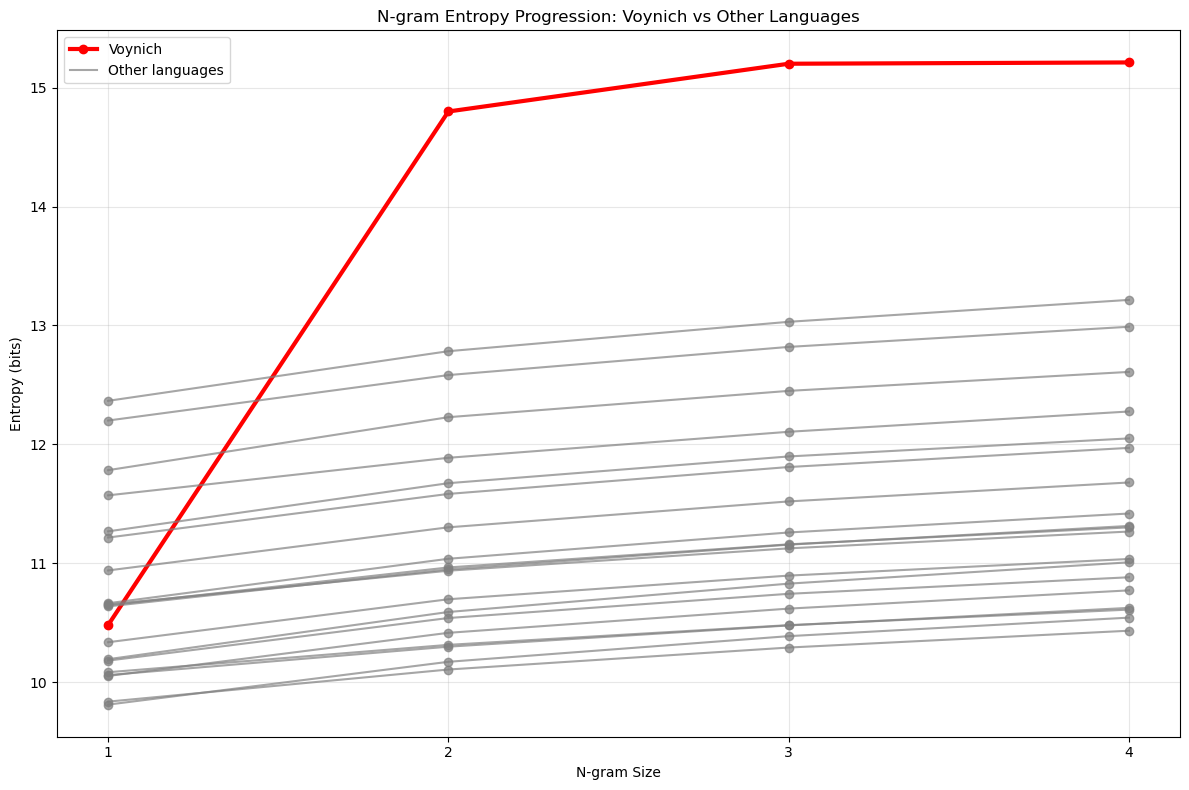


Voynich entropy reduction rate: -0.147
Languages with most similar entropy reduction patterns:
1. maltese: -0.026 (diff: 0.121)
2. irish: -0.024 (diff: 0.122)
3. albanian: -0.023 (diff: 0.123)
4. turkish: -0.023 (diff: 0.124)
5. finnish: -0.023 (diff: 0.124)


In [15]:
# N-gram Entropy
def analyze_ngram_progression():
    print("=== N-GRAM ENTROPY PROGRESSION ANALYSIS ===")
    
    results = {}
    n_values = [1, 2, 3, 4]  # N-gram sizes to analyze
    
    # Iterate through each language
    for lang in LANGS:
        tokens = get_tokens_for_language(lang)
        if tokens:
            lang_results = {}
            # Calculate entropy for each n-gram size
            for n in n_values:
                entropy = calculate_ngram_entropy(tokens, n)
                lang_results[f"{n}-gram"] = entropy
            
            # Calculate entropy values and reduction rates
            entropies = [lang_results[f"{n}-gram"] for n in n_values]
            reduction_rate = []
            for i in range(1, len(entropies)):
                if entropies[i-1] > 0:
                    reduction = (entropies[i-1] - entropies[i]) / entropies[i-1]
                    reduction_rate.append(reduction)
                else:
                    reduction_rate.append(0)
            
            lang_results['avg_reduction_rate'] = np.mean(reduction_rate)
            results[lang] = lang_results
    
    # Create df ordered by reduction rate similarity to Voynich
    if 'voynich' in results:
        voynich_rate = results['voynich']['avg_reduction_rate']
        
        # Sort languages by similarity to Voynich reduction rate
        sorted_langs = sorted(results.keys(), 
                             key=lambda x: abs(results[x]['avg_reduction_rate'] - voynich_rate))
        
        df_ngram = pd.DataFrame({lang: results[lang] for lang in sorted_langs}).T
    else:
        df_ngram = pd.DataFrame(results).T
    
    df_ngram = df_ngram.round(3)  # Round values to 3 decimal places
    
    print("N-gram Entropy Values (ordered by similarity to Voynich):")
    display(df_ngram)
    
    # Plot n-gram entropy progression
    plt.figure(figsize=(12, 8))
    
    for lang in results.keys():
        entropies = [results[lang][f"{n}-gram"] for n in n_values]
        if lang == 'voynich':
            # Highlight Voynich with distinct style
            plt.plot(n_values, entropies, marker='o', label='Voynich', 
                    linewidth=3, color='red')
        else:
            # Plot other languages with gray lines
            plt.plot(n_values, entropies, marker='o', 
                    linewidth=1.5, color='gray', alpha=0.7)
    
    # Add "Other languages" to legend
    plt.plot([], [], color='gray', linewidth=1.5, alpha=0.7, label='Other languages')
    
    plt.xlabel('N-gram Size')
    plt.ylabel('Entropy (bits)')
    plt.title('N-gram Entropy Progression: Voynich vs Other Languages')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(n_values)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if 'voynich' in results:
        voynich_rate = results['voynich']['avg_reduction_rate']
        print(f"\nVoynich entropy reduction rate: {voynich_rate:.3f}")
        
        other_rates = [(lang, data['avg_reduction_rate']) 
                      for lang, data in results.items() if lang != 'voynich']
        other_rates.sort(key=lambda x: abs(x[1] - voynich_rate))
        
        print("Languages with most similar entropy reduction patterns:")
        for i, (lang, rate) in enumerate(other_rates[:5]):
            diff = abs(rate - voynich_rate)
            print(f"{i+1}. {lang}: {rate:.3f} (diff: {diff:.3f})")
    
    return results

ngram_results = analyze_ngram_progression()


=== SYMBOL TRANSITION ENTROPY ANALYSIS ===
Character Transition Analysis:


,Transition_Entropy,Unique_Characters,Avg_Transitions_per_Char
voynich,2.011,24.0,12.625
english,1.458,73.0,9.260
spanish,2.378,38.0,17.500
french,1.583,68.0,11.103
german,1.347,82.0,9.598
russian,2.060,100.0,12.120
turkish,1.957,51.0,12.608
finnish,1.707,74.0,9.419
hungarian,2.555,46.0,18.522
basque,1.205,87.0,7.046


Languages with most similar character transition patterns to Voynich:
1. russian: entropy diff = 0.04856
2. turkish: entropy diff = 0.05444
3. maltese: entropy diff = 0.13335
4. polish: entropy diff = 0.30301
5. finnish: entropy diff = 0.30427


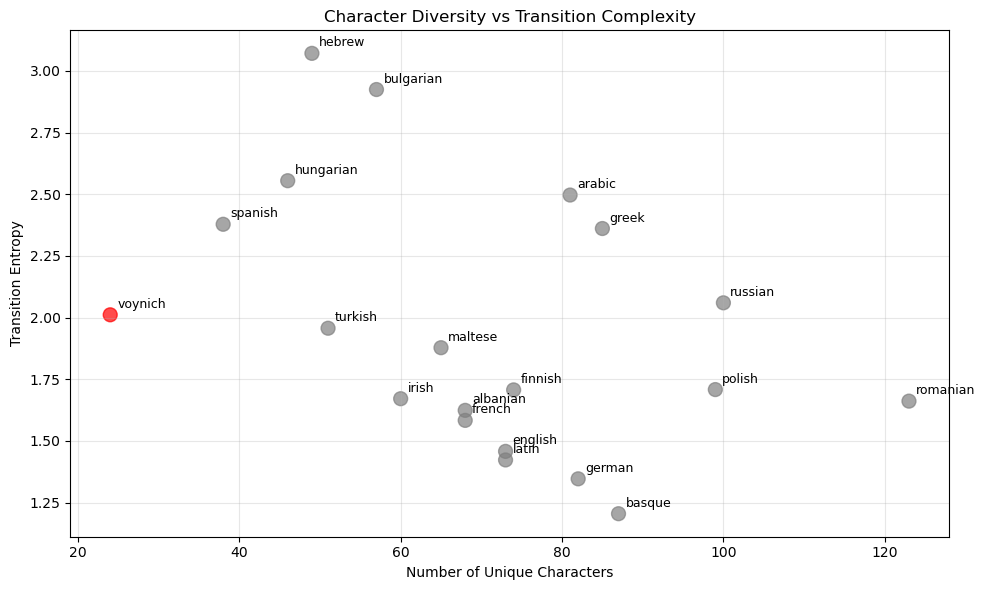

In [16]:
# Symbol Transition Entropy
def analyze_symbol_transitions():
    print("\n=== SYMBOL TRANSITION ENTROPY ANALYSIS ===")
    
    results = {}
    
    # Iterate through each language
    for lang in LANGS:
        tokens = get_tokens_for_language(lang)
        if tokens:
            # Calculate character transitions and related metrics
            transitions = calculate_character_transitions(tokens)
            
            transition_entropy = calculate_transition_entropy(transitions)
            num_unique_chars = len(transitions)
            avg_transitions_per_char = np.mean([len(next_chars) for next_chars in transitions.values()]) if transitions else 0
            
            results[lang] = {
                'transition_entropy': transition_entropy,
                'unique_characters': num_unique_chars,
                'avg_transitions_per_char': avg_transitions_per_char,
                'transitions': transitions
            }
    
    # Create summary DataFrame
    summary_data = {
        lang: {
            'Transition_Entropy': data['transition_entropy'],
            'Unique_Characters': data['unique_characters'],
            'Avg_Transitions_per_Char': data['avg_transitions_per_char']
        }
        for lang, data in results.items()
    }
    
    df_transitions = pd.DataFrame(summary_data).T.round(3)
    
    print("Character Transition Analysis:")
    display(df_transitions)
    
    # Find languages with transition entropy closest to Voynich
    if 'voynich' in results:
        voynich_entropy = results['voynich']['transition_entropy']
        
        similarities = []
        for lang, data in results.items():
            if lang != 'voynich':
                entropy_diff = abs(data['transition_entropy'] - voynich_entropy)
                similarities.append((lang, entropy_diff))
        
        similarities.sort(key=lambda x: x[1])
        
        print(f"Languages with most similar character transition patterns to Voynich:")
        for i, (lang, diff) in enumerate(similarities[:5]):
            print(f"{i+1}. {lang}: entropy diff = {diff:.5f}")
    
    # Plot scatter of character diversity vs transition entropy
    if results:
        plt.figure(figsize=(10, 6))
        
        langs = list(results.keys())
        char_counts = [results[lang]['unique_characters'] for lang in langs]
        entropies = [results[lang]['transition_entropy'] for lang in langs]
        colors = ['red' if lang == 'voynich' else 'gray' for lang in langs]
        
        plt.scatter(char_counts, entropies, c=colors, s=100, alpha=0.7)
        
        # Annotate each point with language name
        for i, lang in enumerate(langs):
            plt.annotate(lang, (char_counts[i], entropies[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel('Number of Unique Characters')
        plt.ylabel('Transition Entropy')
        plt.title('Character Diversity vs Transition Complexity')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return results

transition_results = analyze_symbol_transitions()

#### Word Grammar

This section implements Jorge Stolfi's grammatical analysis of Voynichese words, based on his three-layer structural model. Stolfi's grammar treats each word as having a nested density profile with a "core" layer (gallows letters like t, p, k, f), a "mantle" layer (bench letters like ch, sh and e-groups), and a "crust" layer (dealers, terminals, and initial letters). The model uses statistical frequency data from the actual manuscript to validate word structures and assign probability scores.

The implementation tokenizes words into grammatical units, calculates density profiles, and checks structural constraints like the tendency for density to peak at the core and decline toward word edges. While this represents a simplified version of Stolfi's complete context-free grammar, it captures the essential insight that Voynichese exhibits systematic internal structure rather than random letter sequences, making it a valuable tool for computational analysis of the manuscript's linguistic properties.

In [12]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

class VoynichGrammarValidator:
    def __init__(self):
        # Define character sets based on Stolfi's classifications from the grammar document
        self.GALLOWS = {"k", "t", "p", "f"}  # Core letters: single gallows
        self.PEDESTALS = {"cth", "cph", "ckh", "cfh"}  # Core pedestal combinations (c + gallow + h)
        self.BENCHES = {"ch", "sh", "ee"}  # Mantle benches
        self.ISOLATED_E = {"e"}  # Isolated 'e' treated as mantle
        self.STAVES = {"i", "l", "r", "s"}  # Crust staves (dealers like r, s)
        self.LOOPS = {"a", "o", "y"}  # Circles/modifiers (ignored in density)
        self.LEGS = {"d"}  # Crust leg (dealer d)
        self.JIBS = {"q"}  # Crust jib (initial q)
        self.OTHERS = {"m", "g", "n", "x"}  # Other crust letters (mostly finals)

        # Density levels as per the layered model (higher density inward)
        self.DENSITY_CORE = 3  # Gallows/pedestals
        self.DENSITY_MANTLE = 2  # Benches/isolated e
        self.DENSITY_CRUST = 1  # Dealers/initials/finals
        self.DENSITY_NONE = 0  # Undefined or errors

    # Load and clean the Voynich manuscript text
    def load_and_preprocess_text(self, filepath, treat_commas_as_spaces=True):
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                lines = file.readlines()

            eva_text_segments = []

            for line in lines:
                line = line.strip()

                # Skip empty lines and comment lines starting with '#'
                if not line or line.startswith('#'):
                    continue

                # Match lines with locus identifiers like <f1r> and extract the EVA part
                match = re.match(r'<f[^>]+>\s*(.*)', line)
                if match:
                    eva_part = match.group(1).strip()
                    if eva_part:
                        processed_eva = self.process_eva_text(eva_part, treat_commas_as_spaces)
                        if processed_eva:
                            eva_text_segments.append(processed_eva)

            # Join all segments into a single text string
            final_text = ' '.join(eva_text_segments)
            return final_text

        except FileNotFoundError:
            return None
        except Exception as e:
            return None

    # Process a single EVA text segment
    def process_eva_text(self, eva_text, treat_commas_as_spaces=True):
        if treat_commas_as_spaces:
            eva_text = eva_text.replace(',', ' ')

        # Remove special characters (keep letters and spaces)
        eva_text = re.sub(r'[^\w\s]', ' ', eva_text)
        # Remove digits
        eva_text = re.sub(r'\d', '', eva_text)
        # Normalize multiple spaces to single
        eva_text = re.sub(r'\s+', ' ', eva_text)
        

        return eva_text.strip()

    # Assign density level to a token based on its category.
    def get_character_density(self, token):
        if token in self.GALLOWS or token in self.PEDESTALS:
            return self.DENSITY_CORE
        elif token in self.BENCHES or token in self.ISOLATED_E:
            return self.DENSITY_MANTLE
        elif token in (self.STAVES | self.LEGS | self.JIBS | self.OTHERS):
            return self.DENSITY_CRUST
        else:
            return self.DENSITY_NONE

    # Tokenize a Voynichese word into grammatical units
    def tokenize_word(self, word_string):
        tokens = []
        i = 0
        word_string = word_string.lower().strip()

        while i < len(word_string):
            # Check for 3-char pedestals: 'c' + gallow + 'h'
            if i + 2 < len(word_string) and word_string[i] == 'c' and word_string[i+1] in self.GALLOWS and word_string[i+2] == 'h':
                tokens.append(word_string[i:i+3])
                i += 3
                continue

            # Check for 2-char benches: 'ch', 'sh'
            if i + 1 < len(word_string):
                two_char = word_string[i:i+2]
                if two_char in self.BENCHES:
                    tokens.append(two_char)
                    i += 2
                    continue

            # Check for 'ee' (mantle bench)
            if i + 1 < len(word_string) and word_string[i:i+2] == 'ee':
                tokens.append('ee')
                i += 2
                continue

            # Fall back to single character tokens (e.g., 'e', circles, crust letters)
            tokens.append(word_string[i])
            i += 1

        return tokens

    # Compute the density profile of the word, excluding circle modifiers (a, o, y)
    def calculate_density_profile(self, tokens):
        density_profile = []
        for token in tokens:
            if token in self.LOOPS:
                continue  # Circles are ignored in density profiles as per grammar
            density = self.get_character_density(token)
            density_profile.append(density)  # Append even if 0 for error detection
        return density_profile

    # Identify the core: position of the maximum density in the profile.
    def find_word_core(self, density_profile):
        if not density_profile:
            return -1, 0

        max_density = max(density_profile)
        core_index = density_profile.index(max_density)
        return core_index, max_density

    # Verify unimodal density profile: non-decreasing to core, non-increasing after.
    def check_unimodal_density(self, density_profile, core_index):
        errors = []

        # Prefix: non-decreasing (rises or flat to core)
        for i in range(core_index):
            if density_profile[i] > density_profile[i + 1]:
                errors.append("density_decreases_before_core")
                break

        # Suffix: non-increasing (falls or flat after core)
        for i in range(core_index, len(density_profile) - 1):
            if density_profile[i] < density_profile[i + 1]:
                errors.append("density_increases_after_core")
                break

        return errors

    def check_gallows_rules(self, tokens):
        """
        Check gallows/pedestal rules:
        - Up to 2 per word (in core); >2 is abnormal (multi-gallows).
        """
        errors = []
        gallows_count = sum(1 for token in tokens if token in self.GALLOWS or token in self.PEDESTALS)

        if gallows_count > 2:
            errors.append("multiple_gallows")

        return errors
        
    # Ensure 'q' is only at the word start (initial position).
    def check_q_placement(self, tokens):
        errors = []

        for i, token in enumerate(tokens):
            if token == 'q' and i != 0:
                errors.append("q_misplaced")
                break

        return errors

    # Prohibit adjacent circles (no aa, ao, etc.). 
    def check_adjacent_circles(self, tokens):
        errors = []
        for i in range(len(tokens) - 1):
            if tokens[i] in self.LOOPS and tokens[i+1] in self.LOOPS:
                errors.append("adjacent_circles")
                break
        return errors

    # Ensure 'y' is mostly word-final; error if not at end.
    def check_y_placement(self, tokens):
        errors = []
        for i, token in enumerate(tokens):
            if token == 'y' and i != len(tokens) - 1:
                errors.append("y_misplaced")
                break
        return errors
        
    # Validate single word
    def validate_word(self, word_string):

        if not word_string or len(word_string.strip()) == 0:
            return False, ["empty_word"], {}

        # Tokenize the word
        tokens = self.tokenize_word(word_string)
        if not tokens:
            return False, ["tokenization_failed"], {}

        # Check for no adjacent circles
        adjacent_errors = self.check_adjacent_circles(tokens)

        # Check 'y' is final
        y_errors = self.check_y_placement(tokens)

        # Build density profile (excludes circles)
        density_profile = self.calculate_density_profile(tokens)
        core_index, max_density = self.find_word_core(density_profile)

        # Aggregate errors
        errors = adjacent_errors + y_errors

        # Add unimodal check errors
        unimodal_errors = self.check_unimodal_density(density_profile, core_index)
        errors.extend(unimodal_errors)

        # Add gallows errors
        gallows_errors = self.check_gallows_rules(tokens)
        errors.extend(gallows_errors)

        # Add q placement errors
        q_errors = self.check_q_placement(tokens)
        errors.extend(q_errors)

        # Detect undefined tokens (non-loops with density 0, e.g., standalone 'c')
        undefined_count = sum(1 for t in tokens if self.get_character_density(t) == self.DENSITY_NONE and t not in self.LOOPS)
        if undefined_count > 0:
            errors.append("undefined_tokens")

        # Prepare analysis data
        analysis_data = {
            'tokens': tokens,
            'density_profile': density_profile,
            'core_index': core_index,
            'max_density': max_density,
            'word_length': len(tokens),  # Token count as length
            'token_count': len(tokens),
            'gallows_count': sum(1 for t in tokens if t in self.GALLOWS or t in self.PEDESTALS),
            'benches_count': sum(1 for t in tokens if t in self.BENCHES or t in self.ISOLATED_E),
            'loops_count': sum(1 for t in tokens if t in self.LOOPS)
        }

        is_valid = len(errors) == 0

        # Classify based on validity and structure
        if not is_valid:
            if "multiple_gallows" in errors or (density_profile and density_profile.count(self.DENSITY_CORE) > 2):
                analysis_data['classification'] = 'multi_core'
            elif "adjacent_circles" in errors or "undefined_tokens" in errors:
                analysis_data['classification'] = 'weird'
            else:
                analysis_data['classification'] = 'other_abnormal'
        else:
            if analysis_data.get('max_density', 0) >= 3:
                analysis_data['classification'] = 'highly_structured'
            elif analysis_data.get('max_density', 0) >= 2:
                analysis_data['classification'] = 'moderately_structured'
            else:
                analysis_data['classification'] = 'lowly_structured'

        return is_valid, errors, analysis_data

    def analyze_voynich_text(self, filepath, treat_commas_as_spaces=True, min_word_length=2):
        """
        Analyze the full Voynich text:
        - Load text, split into words, get unique words and frequencies.
        - Validate each unique word, compile into DataFrame.
        - Compute consolidated stats.
        - Focuses on unique words for efficiency.
        """
        # Load and preprocess the text
        text = self.load_and_preprocess_text(filepath, treat_commas_as_spaces)

        if not text:
            return None, None

        # Split into words using delimiters
        all_words = re.split(r'[,.\s=\-]+', text)
        all_words = [w.strip() for w in all_words if w.strip()]

        # Count frequencies
        word_frequencies = Counter(all_words)

        # Filter by min length
        filtered_word_frequencies = {word: freq for word, freq in word_frequencies.items()
                                     if len(word) >= min_word_length}

        unique_words = list(filtered_word_frequencies.keys())

        # Print summary stats
        total_instances = len(all_words)
        filtered_instances = sum(filtered_word_frequencies.values())
        excluded_words = len(word_frequencies) - len(unique_words)
        excluded_instances = total_instances - filtered_instances

        print(f"Total word instances in text: {total_instances:,}")
        print(f"Words shorter than {min_word_length} characters excluded: {excluded_words:,} unique words ({excluded_instances:,} instances)")
        print(f"Unique words to analyze: {len(unique_words):,} (after filtering)")
        print(f"Instances to analyze: {filtered_instances:,} (after filtering)")

        # Store results
        word_results = []

        # Percentiles for frequency ranking
        frequencies = list(filtered_word_frequencies.values())

        # Validate each unique word
        for word in unique_words:
            is_valid, errors, analysis_data = self.validate_word(word)
            freq = filtered_word_frequencies[word]

            # Compute metrics
            frequency_percentile = (sum(1 for f in frequencies if f <= freq) / len(frequencies))
            grammar_score = 1.0 if is_valid else max(0.0, 1.0 - (len(errors) * 0.2))
            structural_complexity = analysis_data.get('max_density', 0) / 3.0

            density_profile = analysis_data.get('density_profile', [])
            density_variance = np.var(density_profile) if density_profile else 0.0
            density_mean = np.mean(density_profile) if density_profile else 0.0

            # Build DataFrame row
            row = {
                'word': word,
                'frequency': freq,
                'frequency_percentile': round(frequency_percentile, 2),
                'word_length': len(word),
                'token_count': analysis_data.get('token_count', 0),
                'is_valid': is_valid,
                'grammar_score': round(grammar_score, 4),
                'error_count': len(errors),
                'structural_complexity': round(structural_complexity, 4),
                'density_variance': round(density_variance, 4),
                'density_mean': round(density_mean, 4),
                'max_density': analysis_data.get('max_density', 0),
                'core_index': analysis_data.get('core_index', -1),
                'gallows_count': analysis_data.get('gallows_count', 0),
                'benches_count': analysis_data.get('benches_count', 0),
                'loops_count': analysis_data.get('loops_count', 0),
                'classification': analysis_data.get('classification', 'non_compliant'),
                'errors': ','.join(errors) if errors else '',
                'density_profile': str(analysis_data.get('density_profile', [])),
                'tokens': ','.join(analysis_data.get('tokens', []))
            }

            word_results.append(row)

        # Create DataFrame from results
        df = pd.DataFrame(word_results)

        # Generate stats
        consolidated_stats = self.generate_consolidated_stats(df, total_instances, filtered_instances)

        return df, consolidated_stats

    def generate_consolidated_stats(self, df, total_instances, filtered_instances):
        """
        Compute summary statistics from the analysis DataFrame.
        - Includes compliance rates, averages, distributions, etc.
        - Focuses on unique words, with instance-weighted metrics for context.
        """
        unique_words = len(df)
        valid_unique_words = df['is_valid'].sum()
        invalid_unique_words = unique_words - valid_unique_words

        # Instance-based (frequency-weighted)
        valid_instances = df[df['is_valid'] == True]['frequency'].sum()
        invalid_instances = df[df['is_valid'] == False]['frequency'].sum()

        # Collect all errors
        all_errors = []
        for errors_str in df['errors']:
            if errors_str:
                all_errors.extend(errors_str.split(','))

        error_counts = Counter(all_errors)

        # Compile stats dict
        stats = {
            'total_instances_original': total_instances,
            'filtered_instances_analyzed': filtered_instances,
            'excluded_instances': total_instances - filtered_instances,
            'filtering_retention_rate': (filtered_instances / total_instances * 100) if total_instances > 0 else 0,

            'unique_words': unique_words,
            'valid_unique_words': valid_unique_words,
            'invalid_unique_words': invalid_unique_words,
            'unique_word_compliance_rate': (valid_unique_words / unique_words * 100) if unique_words > 0 else 0,

            'total_instances': filtered_instances,
            'valid_instances': valid_instances,
            'invalid_instances': invalid_instances,
            'instance_compliance_rate': (valid_instances / filtered_instances * 100) if filtered_instances > 0 else 0,

            'avg_word_length': df['word_length'].mean(),
            'min_word_length': df['word_length'].min(),
            'max_word_length': df['word_length'].max(),
            'median_word_length': df['word_length'].median(),

            'avg_token_count': df['token_count'].mean(),
            'min_token_count': df['token_count'].min(),
            'max_token_count': df['token_count'].max(),

            'avg_max_density': df['max_density'].mean(),
            'core_density_distribution': df['max_density'].value_counts().to_dict(),

            'total_gallows_in_vocab': df['gallows_count'].sum(),
            'total_benches_in_vocab': df['benches_count'].sum(),
            'total_loops_in_vocab': df['loops_count'].sum(),
            'avg_gallows_per_word': df['gallows_count'].mean(),
            'avg_benches_per_word': df['benches_count'].mean(),
            'avg_loops_per_word': df['loops_count'].mean(),

            'error_types': dict(error_counts),
            'most_common_error': error_counts.most_common(1)[0] if error_counts else None,
            'avg_errors_per_word': df['error_count'].mean(),

            'validity_by_length': df.groupby('word_length')['is_valid'].agg(['count', 'sum', 'mean']).to_dict(),

            'most_frequent_words': df.nlargest(10, 'frequency')[['word', 'frequency', 'is_valid']].to_dict('records'),
            'avg_frequency': df['frequency'].mean(),
            'median_frequency': df['frequency'].median(),

            'sample_valid_words': df[df['is_valid'] == True]['word'].head(10).tolist(),
            'sample_invalid_words': df[df['is_valid'] == False][['word', 'errors', 'frequency']].head(10).to_dict('records')
        }

        return stats


def display_grammar_results(df, sort_by='frequency', ascending=False, max_rows=50):
    """
    Display analysis results in a formatted table.
    - Configures pandas for display.
    - Selects key columns.
    - Sorts and prints top rows.
    """
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 15)
    pd.set_option('display.precision', 4)

    display_columns = [
        'word',
        'frequency',
        'frequency_percentile',
        'grammar_score',
        'structural_complexity',
        'density_variance',
        'density_mean',
        'word_length',
        'is_valid',
        'classification',
        'error_count'
    ]

    df_sorted = df.sort_values(sort_by, ascending=ascending)
    result_df = df_sorted[display_columns].head(max_rows)

    print(f"VOYNICH GRAMMAR ANALYSIS (sorted by {sort_by})")
    print("=" * 120)
    print(result_df.to_string(index=True, max_rows=max_rows))

    return result_df


# functions for displaying subsets
def get_top_frequent_words(df, n=20):
    """Display top N frequent words."""
    return display_grammar_results(df, sort_by='frequency', ascending=False, max_rows=n)

def get_most_grammatical_words(df, n=20):
    """Display words with highest grammar scores."""
    return display_grammar_results(df, sort_by='grammar_score', ascending=False, max_rows=n)

def get_invalid_words(df, n=20):
    """Display invalid words by frequency."""
    invalid_df = df[df['is_valid'] == False]
    return display_grammar_results(invalid_df, sort_by='frequency', ascending=False, max_rows=n)


def analyze_voynich_grammar(filepath="transliteration_zl.txt", treat_commas_as_spaces=True, min_word_length=2, display_results=True):

    validator = VoynichGrammarValidator()
    df, stats = validator.analyze_voynich_text(filepath, treat_commas_as_spaces, min_word_length)

    if display_results and df is not None:
        print("=" * 100)
        print("VOYNICH GRAMMAR ANALYSIS SUMMARY")
        print("=" * 100)

        print(f"Original total instances: {stats['total_instances_original']:,}")
        print(f"Instances after filtering (≥{min_word_length} chars): {stats['filtered_instances_analyzed']:,}")
        print(f"Filtering retention rate: {stats['filtering_retention_rate']:.1f}%")
        print(f"Unique words analyzed: {stats['unique_words']:,}")
        print(f"Grammar compliance rate: {stats['unique_word_compliance_rate']:.1f}%")
        print(f"Most common error: {stats['most_common_error']}")
        print()

        get_top_frequent_words(df, 20)

    return df, stats

df, stats = analyze_voynich_grammar("transliteration_zl.txt")

Total word instances in text: 44,679
Words shorter than 2 characters excluded: 52 unique words (6,289 instances)
Unique words to analyze: 7,870 (after filtering)
Instances to analyze: 38,390 (after filtering)
VOYNICH GRAMMAR ANALYSIS SUMMARY
Original total instances: 44,679
Instances after filtering (≥2 chars): 38,390
Filtering retention rate: 85.9%
Unique words analyzed: 7,870
Grammar compliance rate: 73.7%
Most common error: ('y_misplaced', 972)

VOYNICH GRAMMAR ANALYSIS (sorted by frequency)
         word  frequency  frequency_percentile  grammar_score  structural_complexity  density_variance  density_mean  word_length  is_valid         classification  error_count
33      daiin        853                   1.0            1.0                 0.3333            0.0000        1.0000            5      True       lowly_structured            0
164        ol        574                   1.0            1.0                 0.3333            0.0000        1.0000            2      True       lo